In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *

In [2]:
## Read and merge files 
anotation = pd.read_csv('/branchinecta/jbazanwilliamson/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']
ids_hg19['COUNTRY'] = anotation['11-Country']


In [3]:
####Results from chm13_data_gene_regions.py  
## Output is called in the next cell


In [33]:
chm13 = pd.read_csv('/branchinecta/jbazanwilliamson/cnv_analysis/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13 = chm13.drop(columns=['START_GENE', 'END_GENE'])
chm13 = chm13.drop_duplicates()
chm13


/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


SAMPLE   CHR      START        END  SCORE         TYPE  \
0        LP6005441-DNA_B02  chrX     105118     116978      1     DELETION   
18       LP6005441-DNA_B02  chrX    1038532    1048096      1     DELETION   
21       LP6005441-DNA_B02  chrX    1193541    1202443      1     DELETION   
24       LP6005441-DNA_B02  chrX    1296349    1304923      1     DELETION   
26       LP6005441-DNA_B02  chrX    1855267    1863572      1     DELETION   
...                    ...   ...        ...        ...    ...          ...   
1874421  LP6005442-DNA_H01  chr1  247606647  247620901      5  DUPLICATION   
1874427  LP6005442-DNA_H01  chr1  247629795  247637933      4  DUPLICATION   
1874430  LP6005442-DNA_H01  chr1  247738073  247750886      6  DUPLICATION   
1874432  LP6005442-DNA_H01  chr1  247954331  247967419      4  DUPLICATION   
1874434  LP6005442-DNA_H01  chr1  248159841  248170419      3  DUPLICATION   

         LENGHT  
0         11860  
18         9564  
21         8902  
24         8574  
26         8305  
...         ...  
1874421   14254  
1874427    8138  
1874430   12813  
1874432   13088  
1874434   10578  

[472598 rows x 7 columns]

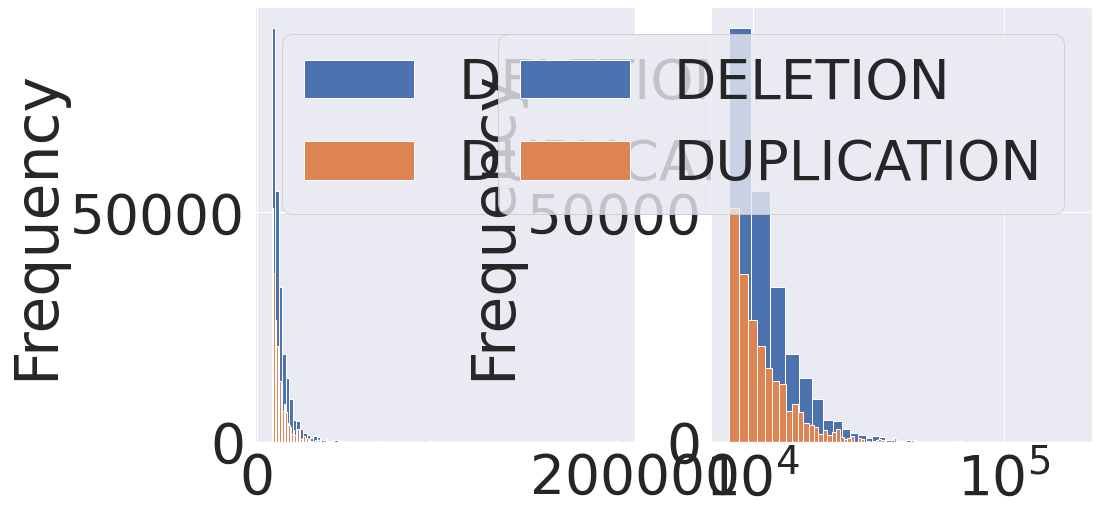

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df_plot= chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df_plot = chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [35]:
#subsetting deletions and duplications
deletions = chm13[chm13['TYPE'] =='DELETION']
duplications = chm13[chm13['TYPE'] == 'DUPLICATION']
deletions

SAMPLE   CHR     START       END  SCORE      TYPE  LENGHT
0       LP6005441-DNA_B02  chrX    105118    116978      1  DELETION   11860
18      LP6005441-DNA_B02  chrX   1038532   1048096      1  DELETION    9564
21      LP6005441-DNA_B02  chrX   1193541   1202443      1  DELETION    8902
24      LP6005441-DNA_B02  chrX   1296349   1304923      1  DELETION    8574
26      LP6005441-DNA_B02  chrX   1855267   1863572      1  DELETION    8305
...                   ...   ...       ...       ...    ...       ...     ...
961216  LP6005442-DNA_H01  chrY  25831552  25849672      0  DELETION   18120
961218  LP6005442-DNA_H01  chrY  25849672  25870481      0  DELETION   20809
961223  LP6005442-DNA_H01  chrY  25870481  25903787      0  DELETION   33306
961225  LP6005442-DNA_H01  chrY  26436587  26458551      0  DELETION   21964
961231  LP6005442-DNA_H01  chrY  26778516  26788355      0  DELETION    9839

[241750 rows x 7 columns]

In [36]:
#change to df when using telomeres and centromeres filtration
final_cnv = deletions.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


final_cnv = final_cnv.dropna(thresh=30)
final_cnv

SAMPLE   CHR     START       END  LP6005441-DNA_A01  LP6005441-DNA_A03  \
0       chr1    521722    540598                NaN                NaN   
2       chr1   1041679   1050074                NaN                NaN   
3       chr1   1199726   1209870                NaN                NaN   
4       chr1   1382671   1391067                NaN                NaN   
8       chr1   2086549   2277495                NaN                NaN   
...      ...       ...       ...                ...                ...   
8179    chrY  25831552  25849672                NaN                0.0   
8180    chrY  25849672  25870481                NaN                0.0   
8181    chrY  25870481  25903787                NaN                0.0   
8182    chrY  26436587  26458551                NaN                0.0   
8183    chrY  26778516  26788355                NaN                0.0   

SAMPLE  LP6005441-DNA_A04  LP6005441-DNA_A05  LP6005441-DNA_A06  \
0                     NaN                NaN                NaN   
2                     1.0                1.0                NaN   
3                     NaN                NaN                NaN   
4                     NaN                NaN                NaN   
8                     NaN                NaN                NaN   
...                   ...                ...                ...   
8179                  0.0                NaN                NaN   
8180                  0.0                NaN                NaN   
8181                  0.0                NaN                NaN   
8182                  0.0                NaN                NaN   
8183                  0.0                NaN                NaN   

SAMPLE  LP6005441-DNA_A08  LP6005441-DNA_A09  ...  LP6005677-DNA_D03  \
0                     NaN                NaN  ...                1.0   
2                     1.0                NaN  ...                1.0   
3                     NaN                NaN  ...                NaN   
4                     NaN                NaN  ...                NaN   
8                     NaN                1.0  ...                NaN   
...                   ...                ...  ...                ...   
8179                  NaN                1.0  ...                0.0   
8180                  NaN                1.0  ...                0.0   
8181                  NaN                1.0  ...                0.0   
8182                  NaN                NaN  ...                0.0   
8183                  NaN                NaN  ...                0.0   

SAMPLE  LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     NaN                1.0                NaN   
8                     NaN                NaN                NaN   
...                   ...                ...                ...   
8179                  NaN                0.0                NaN   
8180                  NaN                0.0                NaN   
8181                  NaN                1.0                NaN   
8182                  NaN                0.0                NaN   
8183                  NaN                0.0                NaN   

SAMPLE  LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  \
0                     NaN                NaN        1.0        NaN        1.0   
2                     1.0                1.0        1.0        NaN        NaN   
3                     NaN                NaN        1.0        1.0        NaN   
4                     NaN                NaN        NaN        NaN        NaN   
8                     1.0                1.0        1.0        1.0        1.0   
...                   ...                ...        ...        ...        ...   
8179                  NaN                0.0        NaN        NaN   

In [37]:
from scipy import stats
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,3:284]
counts = final
counts = counts.fillna(2)

#counts = counts[counts.columns.intersection(counts_a.columns)]

#counts = counts.drop(columns=['LP6005592-DNA_G03',
#                     'LP6005443-DNA_E10',
#                     'LP6005442-DNA_E04'])

counts = counts.T
counts = counts.sort_index()
counts

0     2     3     4     8     26    27    28    31    32    \
SAMPLE                                                                          
LP6005441-DNA_A01   2.0   2.0   2.0   2.0   2.0   2.0   1.0   2.0   1.0   1.0   
LP6005441-DNA_A03   2.0   2.0   2.0   2.0   2.0   1.0   2.0   2.0   2.0   1.0   
LP6005441-DNA_A04   2.0   1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
LP6005441-DNA_A05   2.0   1.0   2.0   2.0   2.0   2.0   1.0   2.0   2.0   2.0   
LP6005441-DNA_A06   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
LP6007069-DNA_A01   2.0   1.0   2.0   2.0   1.0   2.0   2.0   2.0   2.0   1.0   
SS6004471           1.0   1.0   1.0   2.0   1.0   2.0   2.0   2.0   1.0   1.0   
SS6004477           2.0   2.0   1.0   2.0   1.0   2.0   2.0   1.0   2.0   2.0   
SS6004478           1.0   2.0   2.0   2.0   1.0   1.0   2.0   2.0   2.0   1.0   
SS6004480           1.0   2.0   2.0   2.0   1.0   2.0   2.0   2.0   1.0   1.0   

                   ...  8174  8175  8176  8177  8178  8179  8180  8181  8182  \
SAMPLE             ...                                                         
LP6005441-DNA_A01  ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
LP6005441-DNA_A03  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
LP6005441-DNA_A04  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
LP6005441-DNA_A05  ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
LP6005441-DNA_A06  ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
LP6007069-DNA_A01  ...   0.0   1.0   1.0   0.0   0.0   0.0   1.0   1.0   0.0   
SS6004471          ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
SS6004477          ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
SS6004478          ...   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   
SS6004480          ...   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   

                   8183  
SAMPLE                   
LP6005441-DNA_A01   2.0  
LP6005441-DNA_A03   0.0  
LP6005441-DNA_A04   0.0  
LP6005441-DNA_A05   2.0  
LP6005441-DNA_A06   2.0  
...                 ...  
LP6007069-DNA_A01   0.0  
SS6004471           2.0  
SS6004477           2.0  
SS6004478           0.0  
SS6004480           2.0  

[269 rows x 1811 columns]

In [38]:
features = ids_hg19.set_index('SAMPLE').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['REGION', 'COUNTRY']]
features = features.sort_index()
features 

REGION           COUNTRY
SAMPLE                                          
LP6005441-DNA_A01  WestEurasia  Russia(Caucasus)
LP6005441-DNA_A03      Oceania    PapuaNewGuinea
LP6005441-DNA_A04      America          Colombia
LP6005441-DNA_A05  WestEurasia            France
LP6005441-DNA_A06  WestEurasia    Italy(Bergamo)
...                        ...               ...
LP6007069-DNA_A01  WestEurasia            Greece
SS6004471               Africa             Congo
SS6004477              Oceania         Australia
SS6004478              Oceania         Australia
SS6004480               Africa             Sudan

[269 rows x 2 columns]

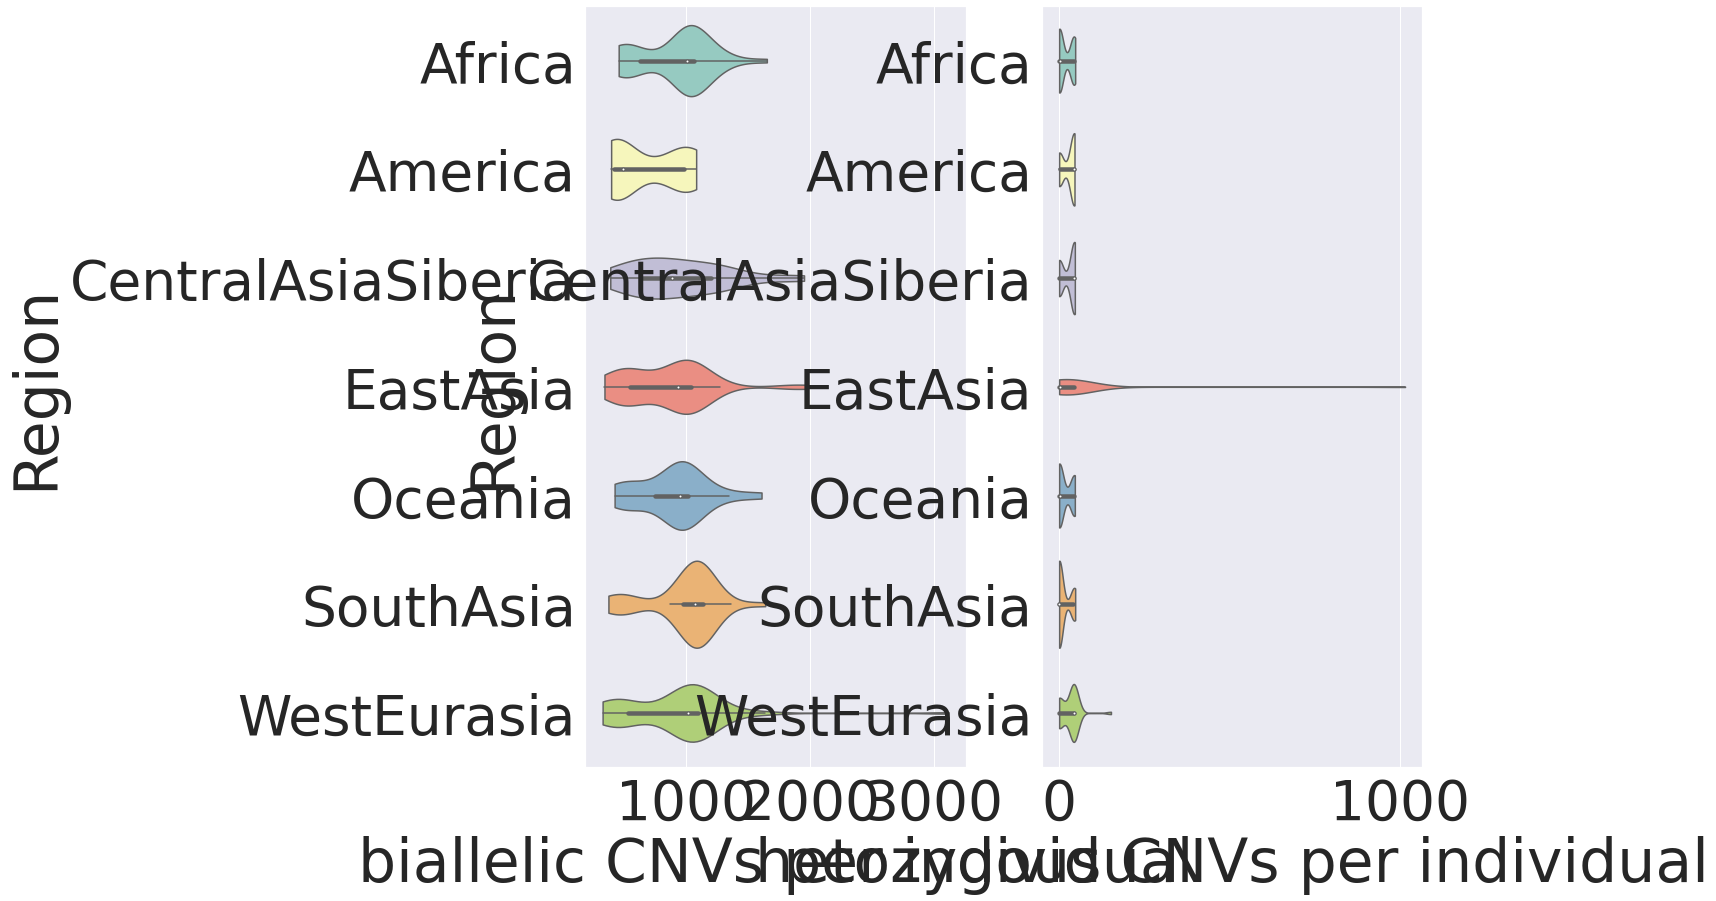

In [39]:
#import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)
biallelic_deletions = deletions[deletions['SCORE'] < 2 ] 
biallelic_deletions = biallelic_deletions.groupby('SAMPLE').size()

biallelic_deletions = pd.DataFrame(biallelic_deletions)
#biallelic_deletions = biallelic_deletions.set_index('SAMPLE')

biallelic_deletions = features.merge(biallelic_deletions, left_index=True, right_index=True)
#biallelic_deletions = biallelic_deletions.reset_index()

#heterozygous_deletions.value_counts('SAMPLE').sort_index()
biallelic_deletions.columns = ['REGION', 'COUNTRY','TYPE']
biallelic_deletions


#pd.set_option("display.max_rows", None, "display.max_columns", None)
heterozygous_deletions = deletions[deletions['SCORE'] < 1] 
heterozygous_deletions = heterozygous_deletions.groupby('SAMPLE').size()
heterozygous_deletions = pd.DataFrame(heterozygous_deletions)
heterozygous_deletions = features.merge(heterozygous_deletions, left_index=True, right_index=True)
heterozygous_deletions.columns = ['REGION','COUNTRY', 'TYPE']
heterozygous_deletions
heterozygous_deletions


fig, axs = plt.subplots(1, 2, figsize=(15, 14))

ax = seaborn.violinplot(x="TYPE", y="REGION", data=biallelic_deletions, palette='Set3', order=[ "Africa","America", "CentralAsiaSiberia","EastAsia", "Oceania", "SouthAsia", "WestEurasia"], ax=axs[0], cut=0)

ax.set_xlabel("biallelic CNVs per individual")
ax.set_ylabel("Region")

ax = seaborn.violinplot(x="TYPE", y="REGION", data=heterozygous_deletions, palette='Set3', order=[ "Africa","America", "CentralAsiaSiberia","EastAsia", "Oceania", "SouthAsia", "WestEurasia"], ax=axs[1], cut=0)

ax.set_xlabel("hetozygous CNVs per individual")
ax.set_ylabel("Region")
plt.show()

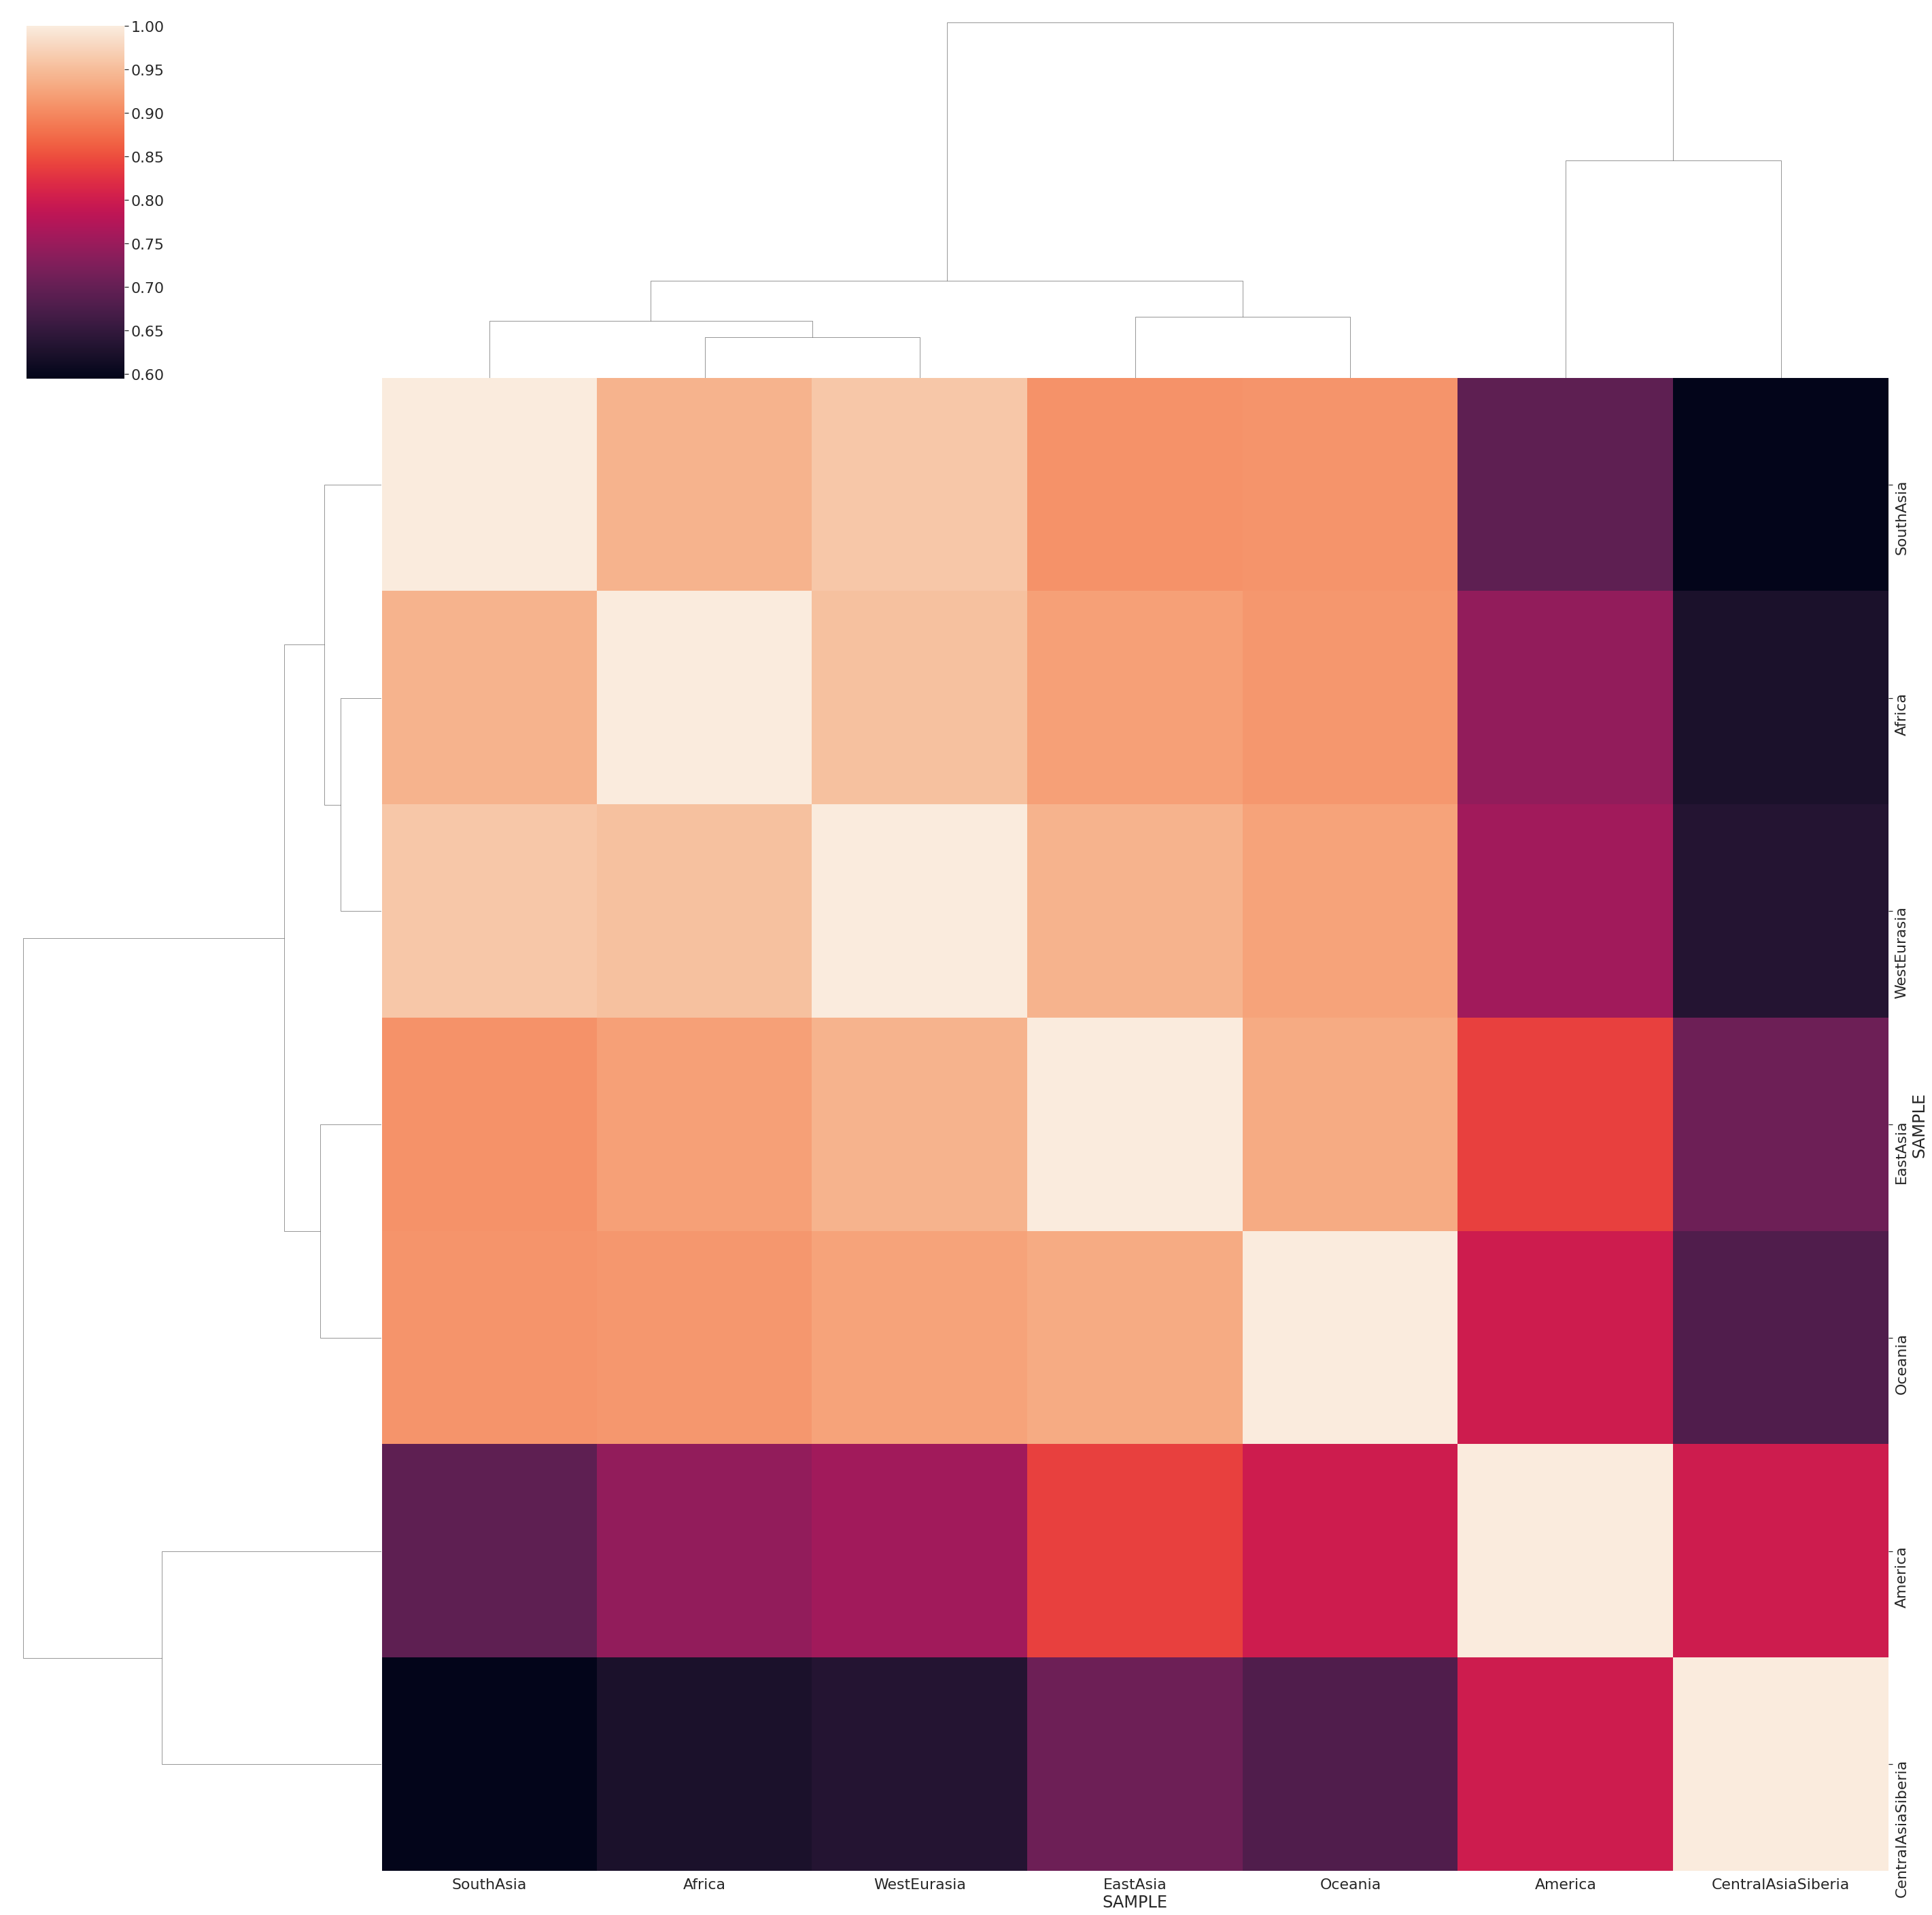

In [40]:
freq = final_cnv.iloc[:,3:283]
freq_input = freq.rename(columns=features['REGION'])
df = freq_input.T

df = df.notnull().groupby(level=0).mean()

seaborn.set(font_scale=2)
corrmatrix = df.T.corr(method='pearson')
seaborn.clustermap(corrmatrix, figsize=(40,40))#, row_colors=row_colors, row_cluster=True, figsize=(40,40))



In [41]:
X

array([[ 0.53579972,  0.62177   ,  0.51852476, ...,  0.79391626,
         0.79391626,  0.79704603],
       [ 0.53579972,  0.62177   ,  0.51852476, ..., -1.25957868,
        -1.25957868, -1.26454418],
       [ 0.53579972, -1.60831174,  0.51852476, ..., -1.25957868,
        -1.25957868, -1.26454418],
       ...,
       [ 0.53579972,  0.62177   , -1.92854822, ...,  0.79391626,
         0.79391626,  0.79704603],
       [-1.86636902,  0.62177   ,  0.51852476, ..., -1.25957868,
        -1.25957868, -1.26454418],
       [-1.86636902,  0.62177   ,  0.51852476, ...,  0.79391626,
         0.79391626,  0.79704603]])

In [42]:
#track features for pca & tsne
from sklearn import preprocessing

X =preprocessing.scale(counts)

#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(X)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

REGION           COUNTRY  component_1  component_2  \
SAMPLE                                                                       
LP6005441-DNA_A01  WestEurasia  Russia(Caucasus)   -19.161443    -2.995557   
LP6005441-DNA_A03      Oceania    PapuaNewGuinea    31.807464     3.602552   
LP6005441-DNA_A04      America          Colombia    31.762477    -5.923954   
LP6005441-DNA_A05  WestEurasia            France   -18.988302   -11.411942   
LP6005441-DNA_A06  WestEurasia    Italy(Bergamo)   -19.445752   -11.151946   
...                        ...               ...          ...          ...   
LP6007069-DNA_A01  WestEurasia            Greece    27.259538    12.144849   
SS6004471               Africa             Congo   -18.698837    11.402200   
SS6004477              Oceania         Australia   -18.825988    15.283388   
SS6004478              Oceania         Australia    30.224380    12.191090   
SS6004480               Africa             Sudan   -19.082685     3.634804   

                   component_3  component_4  component_5  component_6  \
SAMPLE                                                                  
LP6005441-DNA_A01     1.096529    -2.410939    -3.483565    -2.102028   
LP6005441-DNA_A03     2.105363    -2.559586    -4.391589    -3.822745   
LP6005441-DNA_A04     0.356669    -1.139822    -0.369322    -1.551680   
LP6005441-DNA_A05    -0.617426    -2.103088    -4.373902     4.145777   
LP6005441-DNA_A06     0.030692    -1.050425    -0.500159    -0.385573   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01    -8.174460    24.326795     5.389416     5.121857   
SS6004471            -0.321753    27.710523    -0.841114     2.858075   
SS6004477             0.493800    23.221078     0.725690    -2.789624   
SS6004478            -4.034558    25.748805     5.031833     2.311803   
SS6004480            -6.786050    20.720650     1.195010     3.782474   

                   component_7  component_8  component_9  component_10  
SAMPLE                                                                  
LP6005441-DNA_A01    -1.042772    -0.999892    -3.494713     -1.841409  
LP6005441-DNA_A03     2.784328    -0.022887    -1.738414     -2.745112  
LP6005441-DNA_A04     1.282022    -0.596023     0.981268      0.187076  
LP6005441-DNA_A05     2.049845     0.146524    -1.615470     -1.246486  
LP6005441-DNA_A06    -0.344850     0.960946    -2.046380     -1.576553  
...                        ...          ...          ...           ...  
LP6007069-DNA_A01     0.391990     3.575555    -2.063013     -4.489052  
SS6004471             5.628236    -4.392487    -2.245434      1.361872  
SS6004477            -0.618951    -2.062996    -0.215037     -0.268874  
SS6004478             3.435575    -1.541206     2.696196     -4.946850  
SS6004480            -1.020721    10.314818    -1.065133     -3.082734  

[269 rows x 12 columns]

In [43]:
pca.explained_variance_ratio_

array([0.33247806, 0.04984206, 0.01143937, 0.00996523, 0.00810913,
       0.00762936, 0.0061293 , 0.00582255, 0.00530098, 0.0049988 ])

                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  component_5  component_6  component_7

Count of groups by factor: 7
                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  componen

                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  component_5  component_6  component_7

/branchinecta/jbazanwilliamson/cnv_analysis/cnv_sgdp/scripts/pca_plot.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  tight_layout=True


Count of groups by factor: 7
                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  componen

Count of groups by factor: 7
                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  componen

Count of groups by factor: 7
                      COUNTRY  component_1  component_2  component_3  \
REGION                                                                 
WestEurasia  Russia(Caucasus)   -19.161443    -2.995557     1.096529   
Oceania        PapuaNewGuinea    31.807464     3.602552     2.105363   
America              Colombia    31.762477    -5.923954     0.356669   
WestEurasia            France   -18.988302   -11.411942    -0.617426   
WestEurasia    Italy(Bergamo)   -19.445752   -11.151946     0.030692   
...                       ...          ...          ...          ...   
WestEurasia            Greece    27.259538    12.144849    -8.174460   
Africa                  Congo   -18.698837    11.402200    -0.321753   
Oceania             Australia   -18.825988    15.283388     0.493800   
Oceania             Australia    30.224380    12.191090    -4.034558   
Africa                  Sudan   -19.082685     3.634804    -6.786050   

             component_4  componen

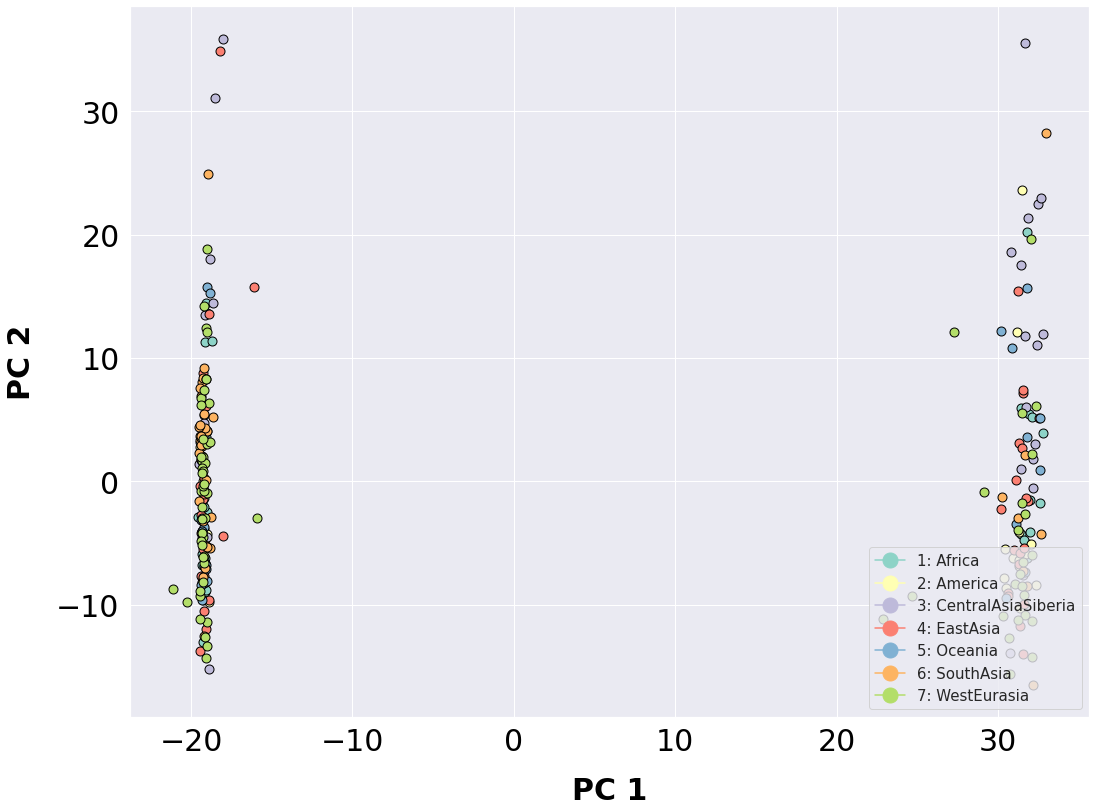

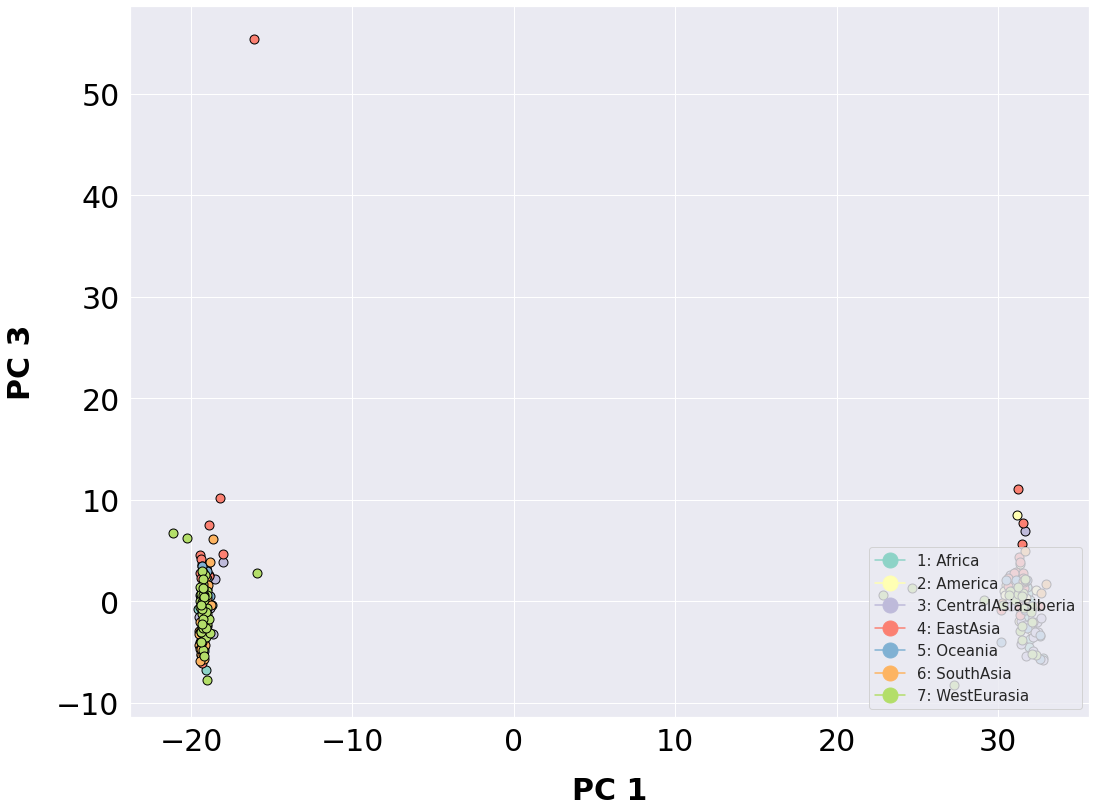

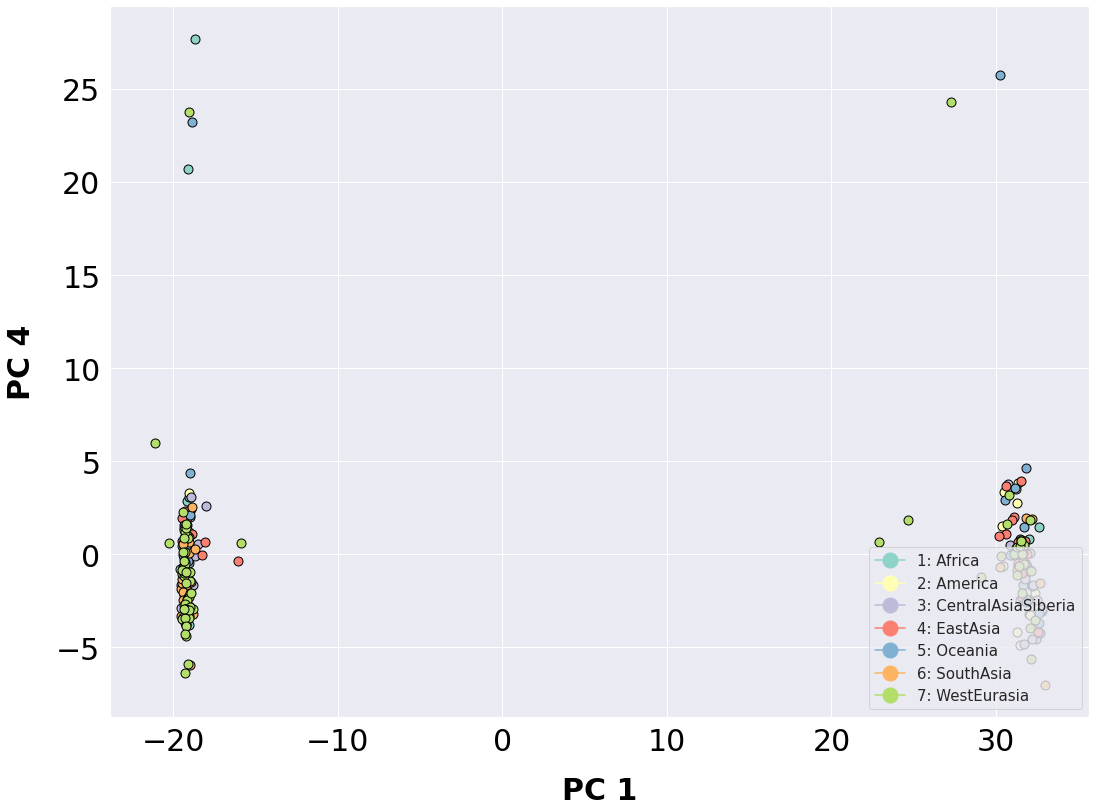

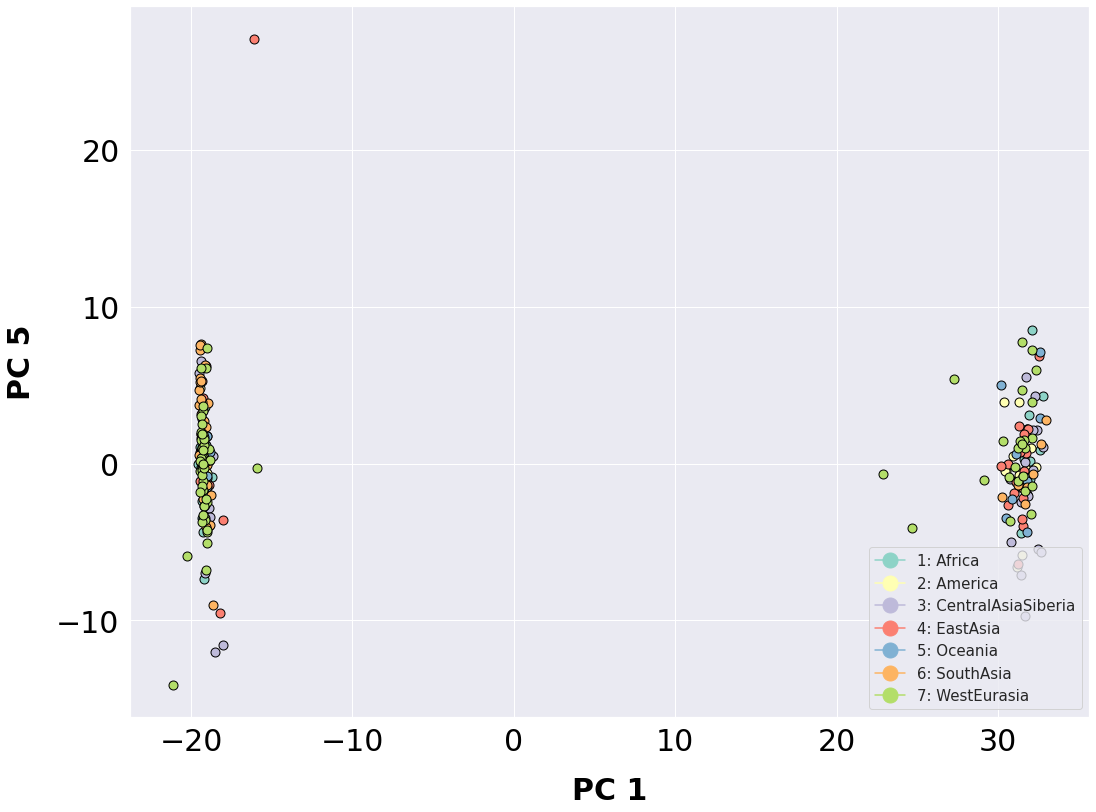

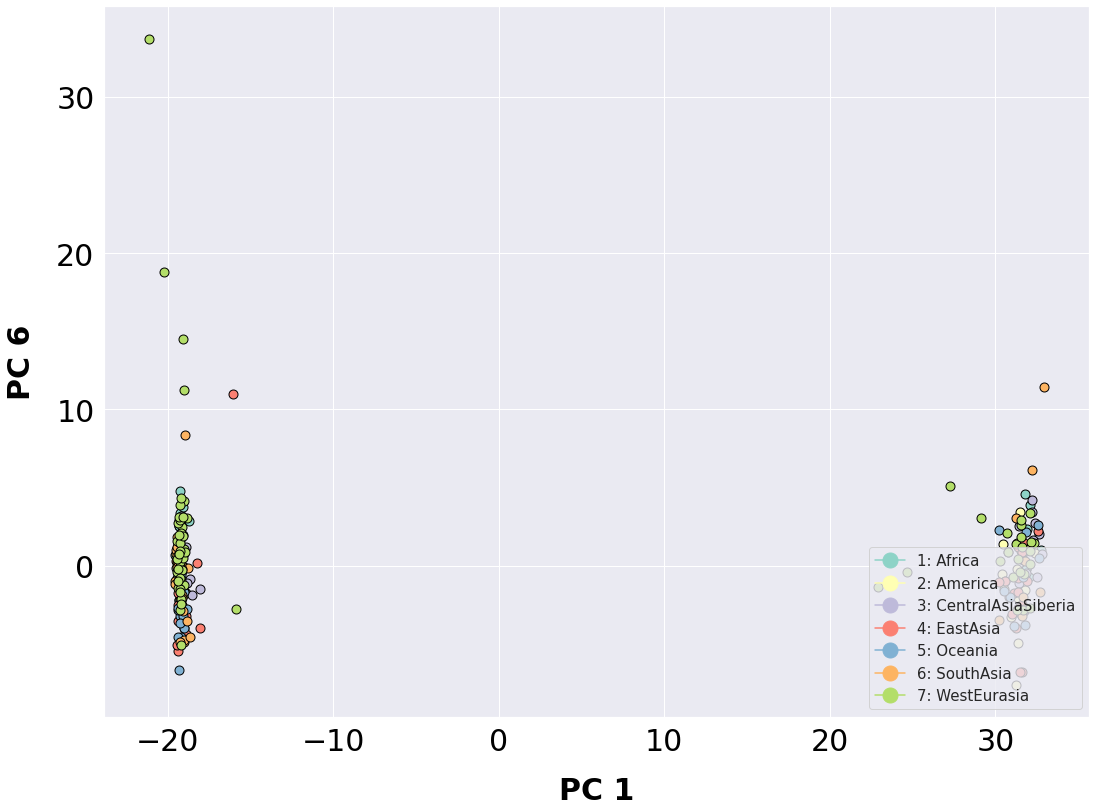

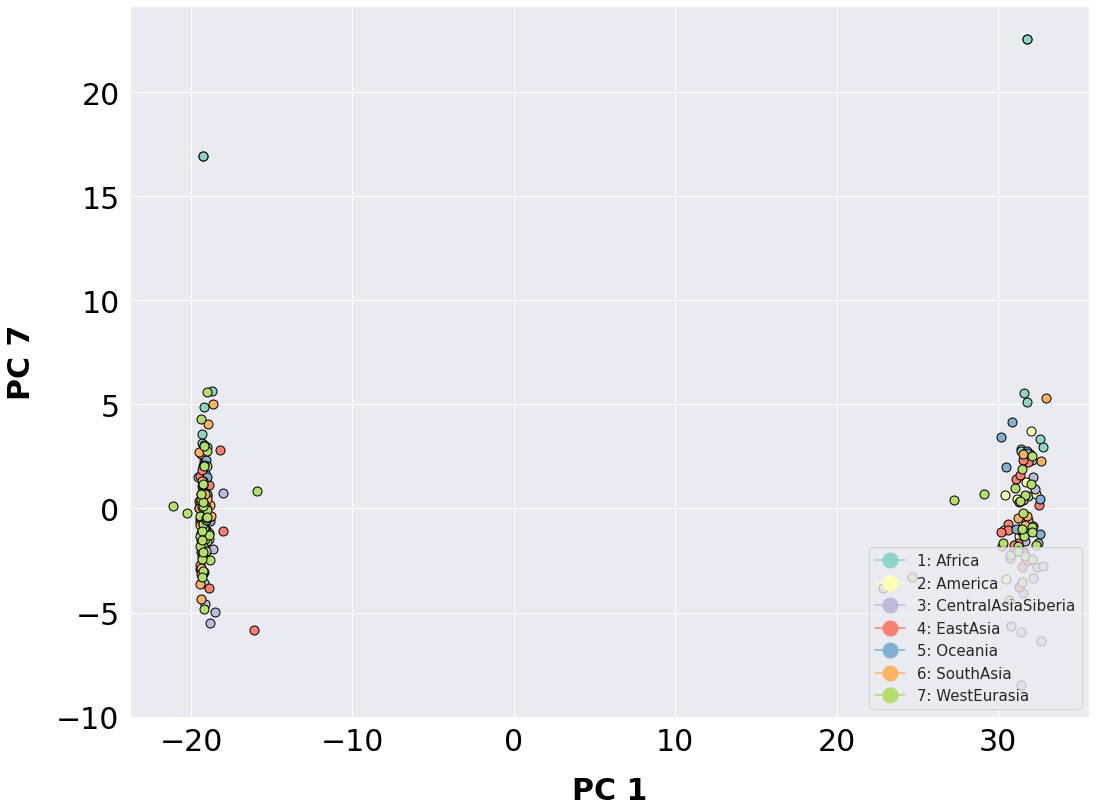

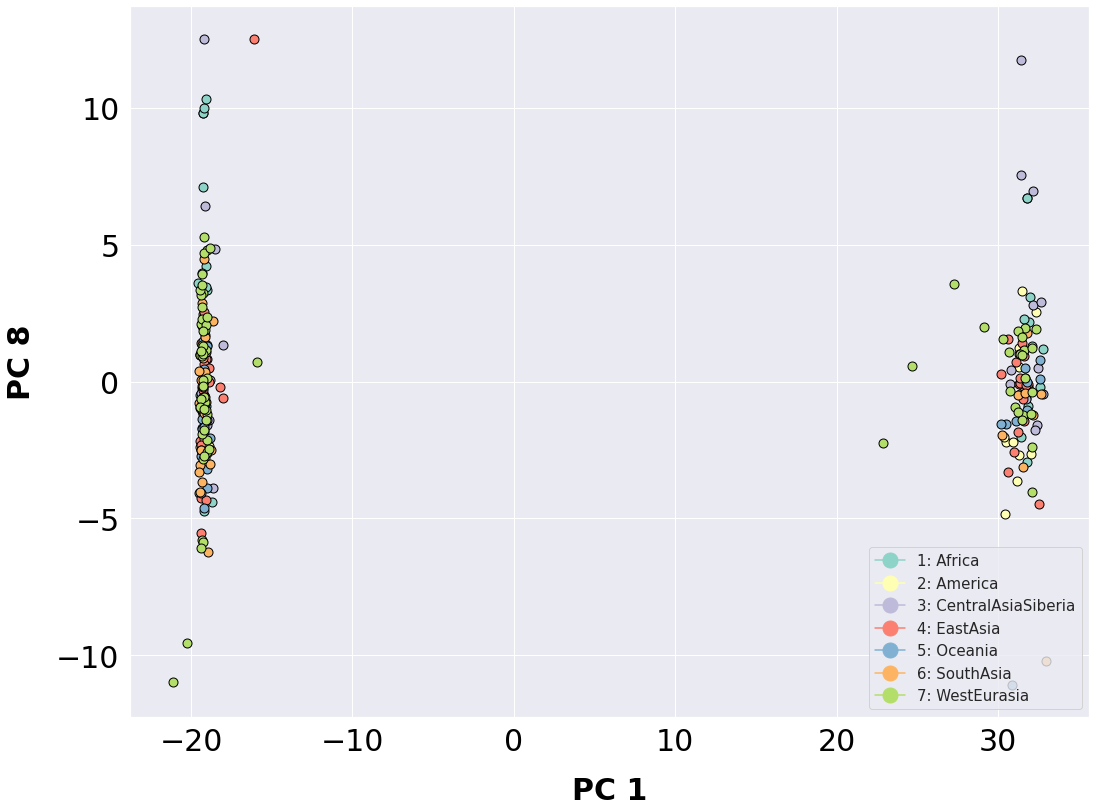

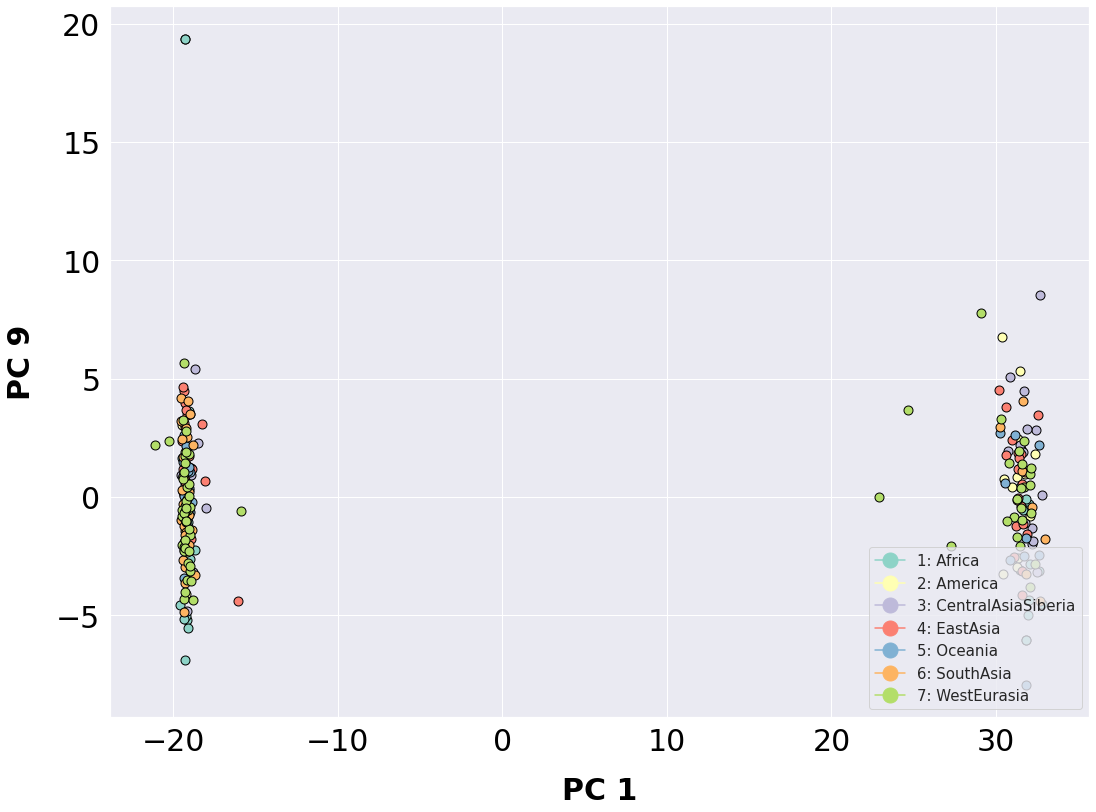

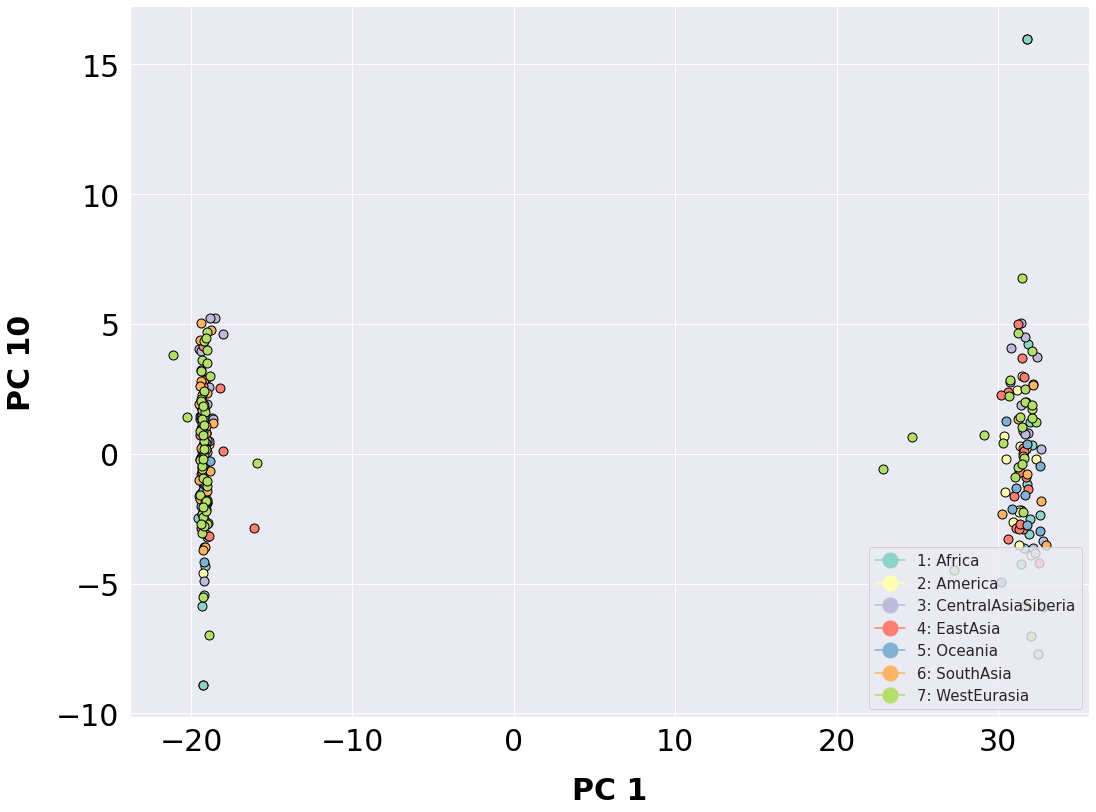

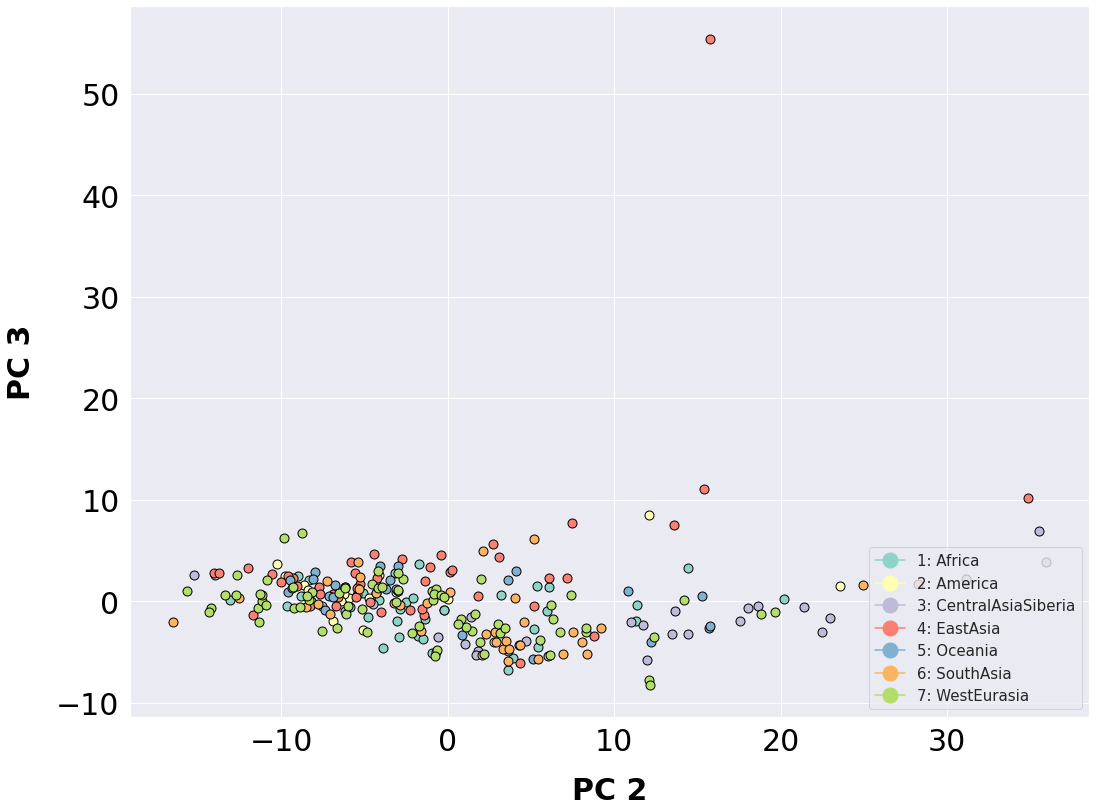

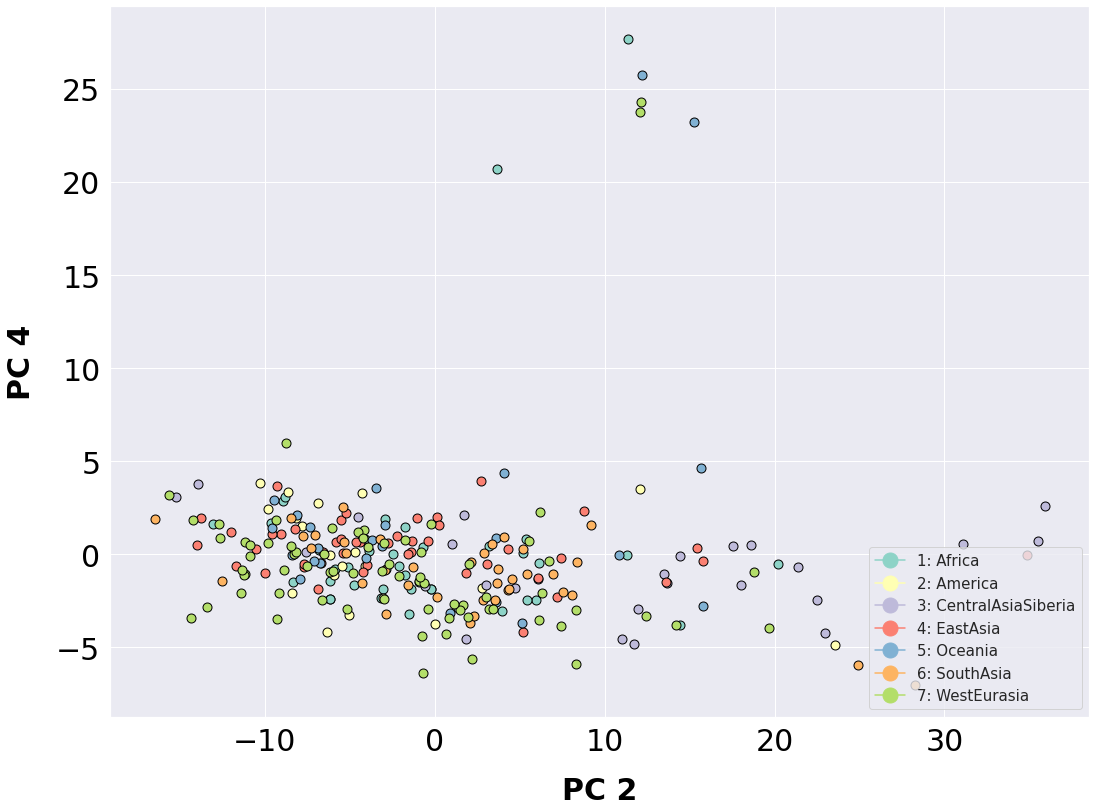

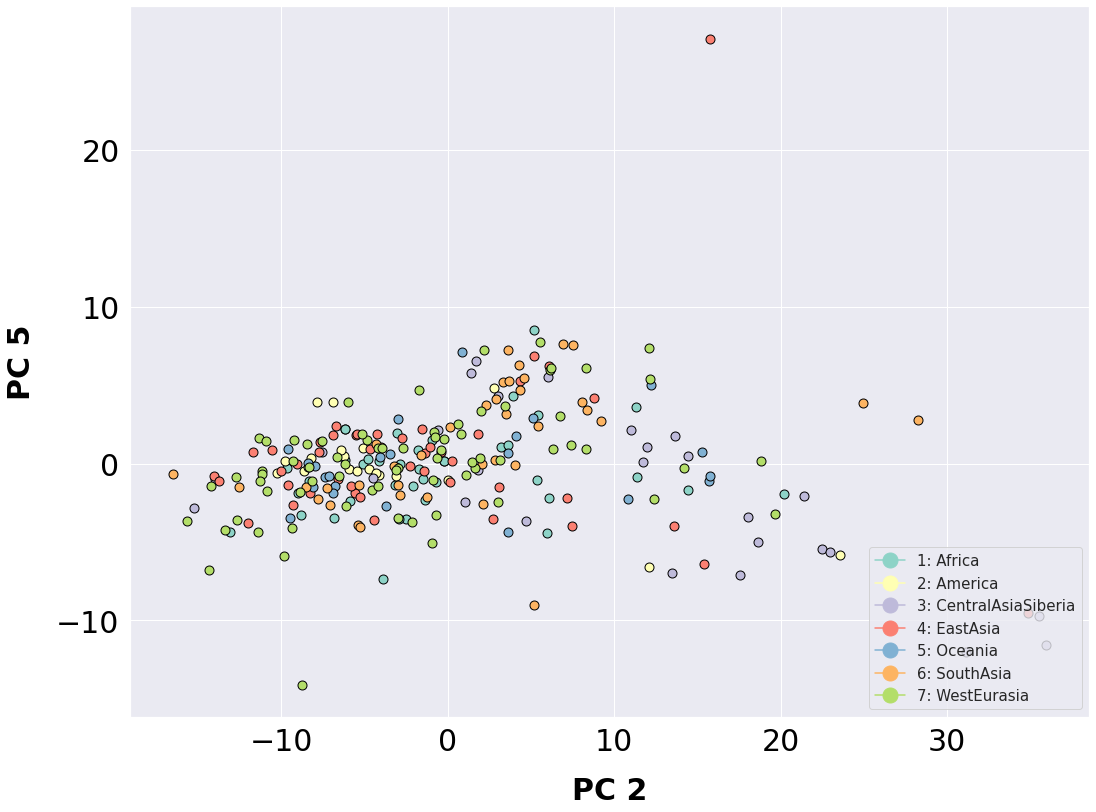

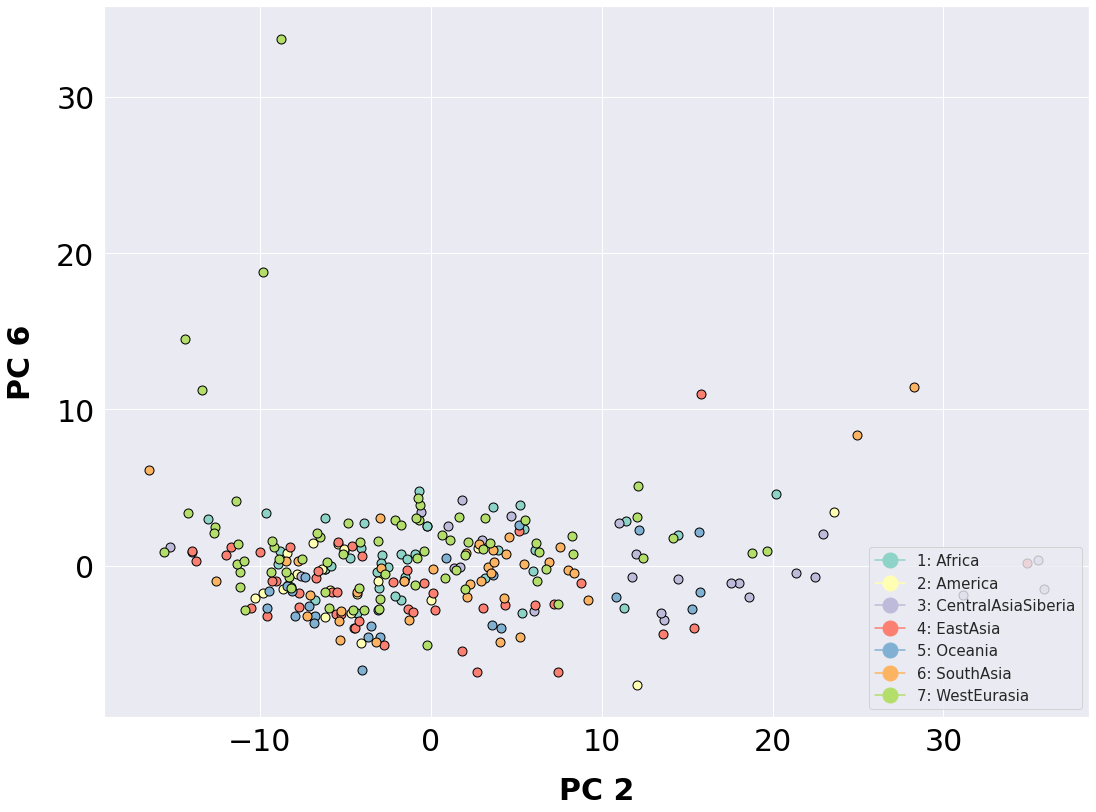

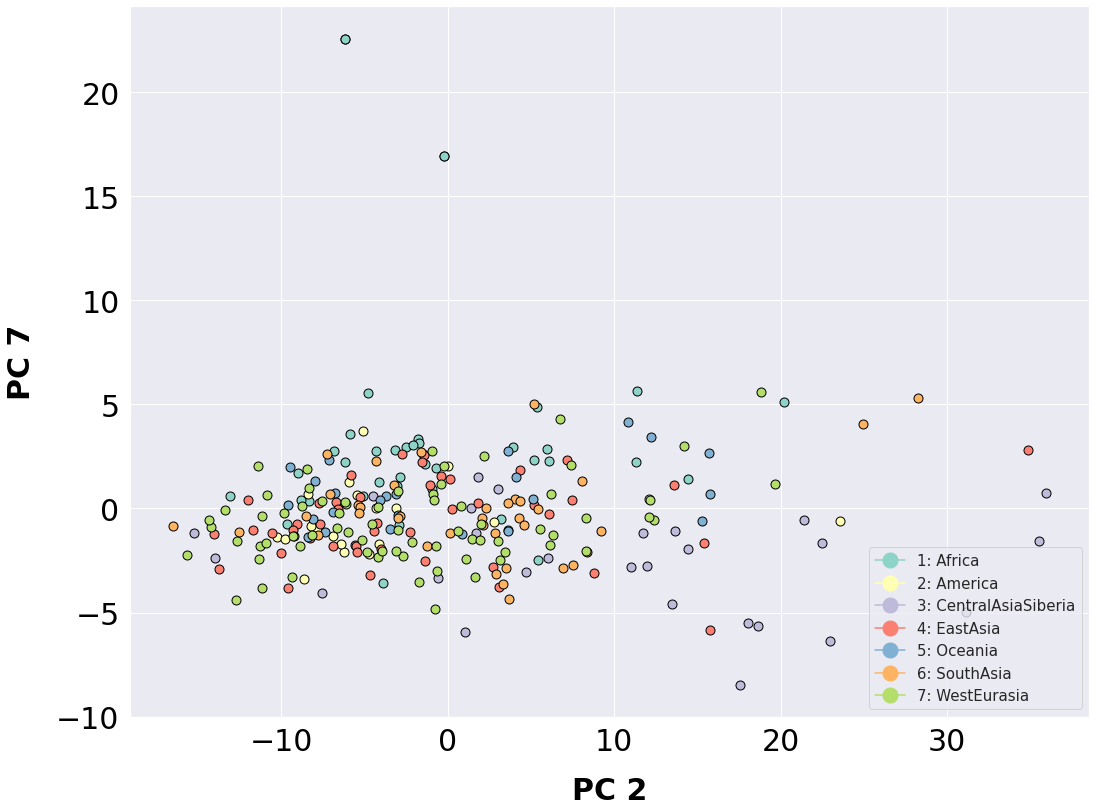

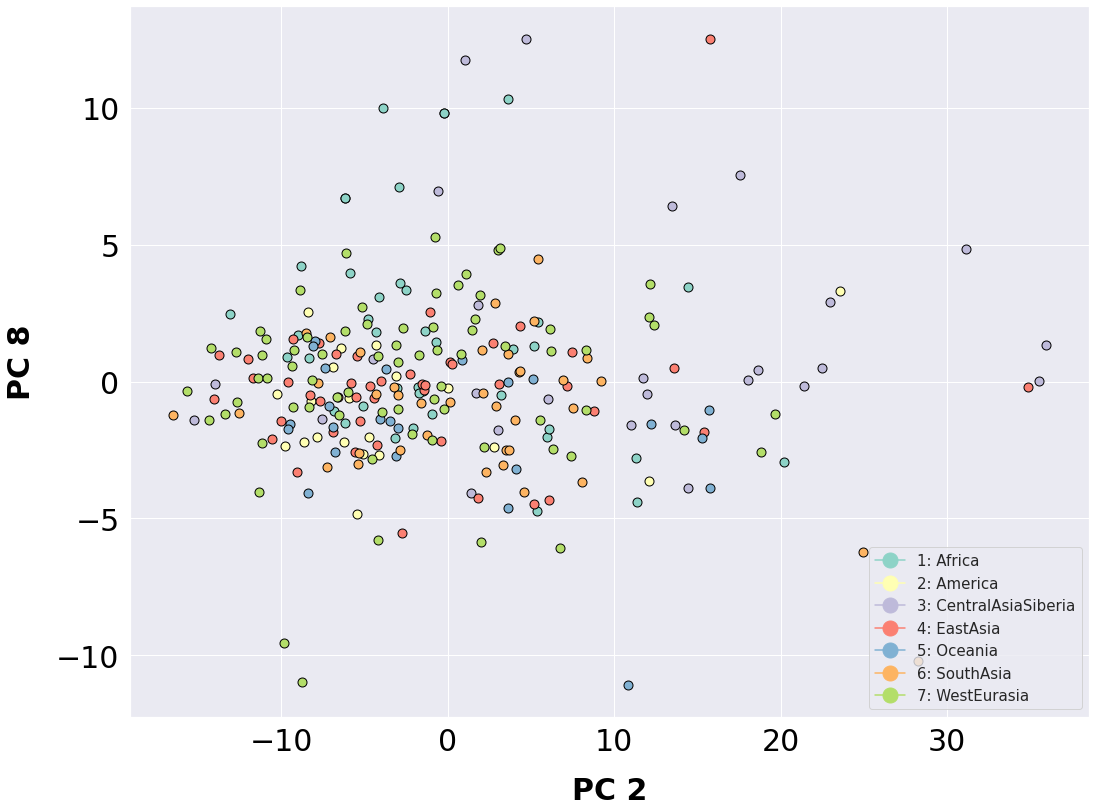

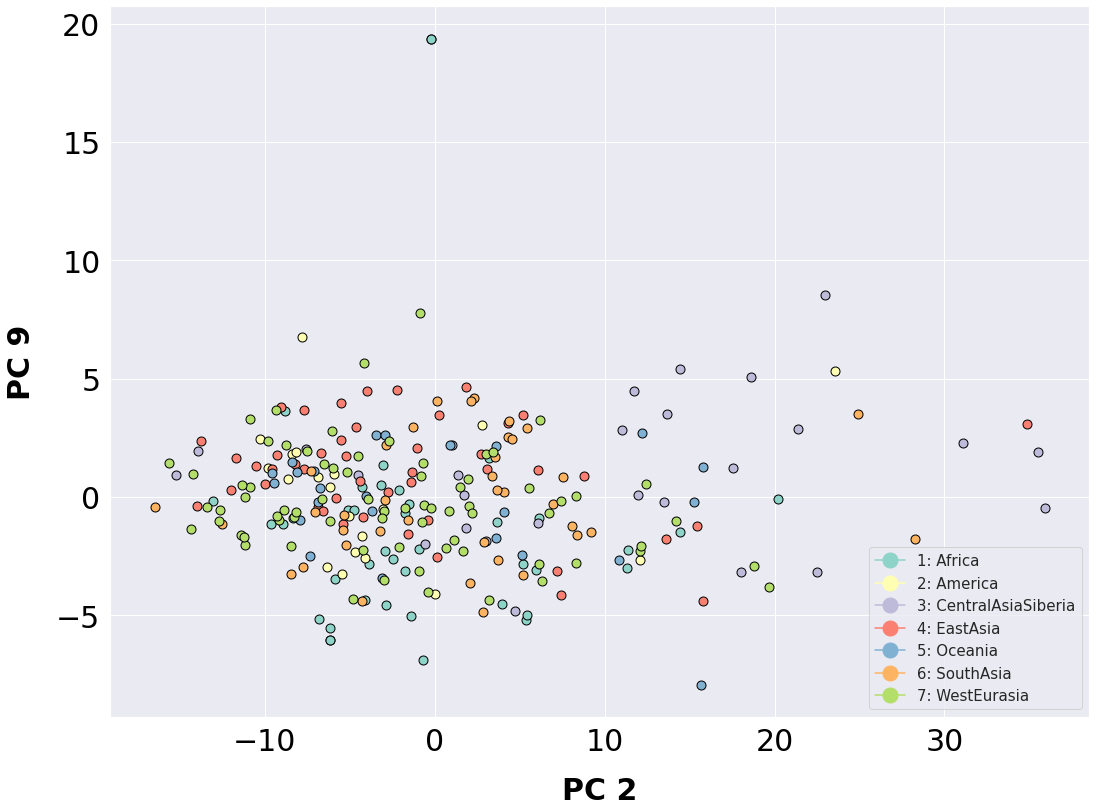

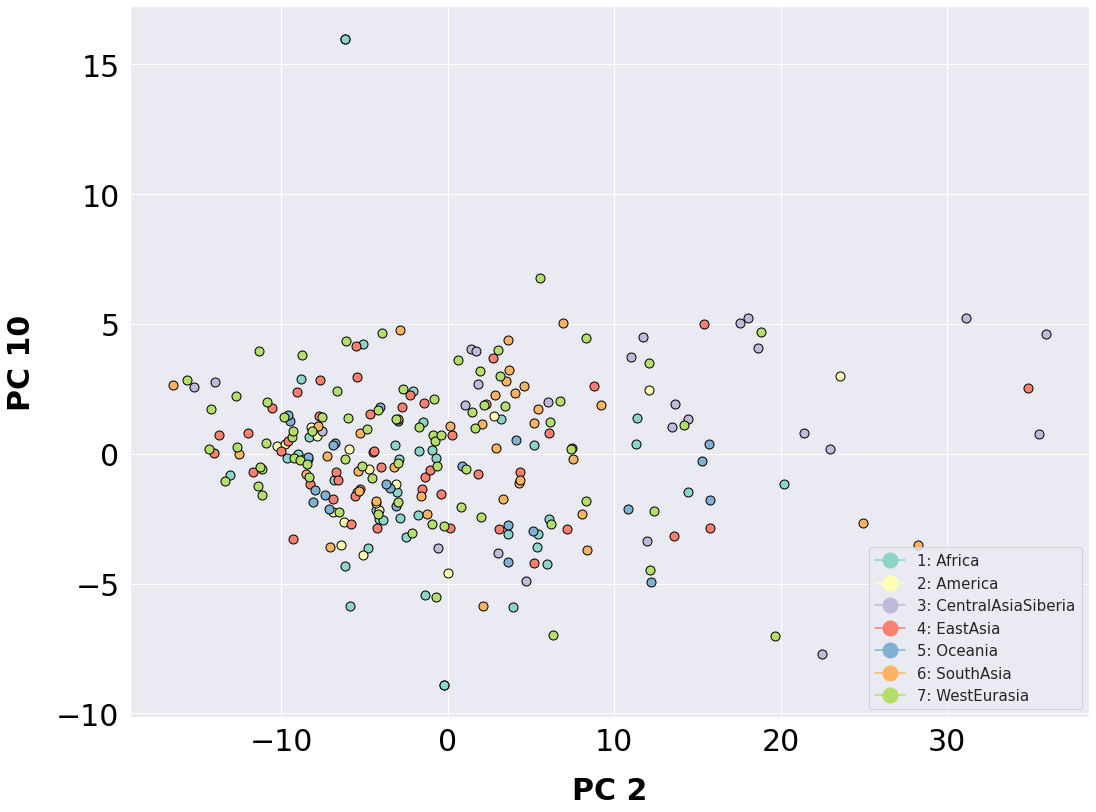

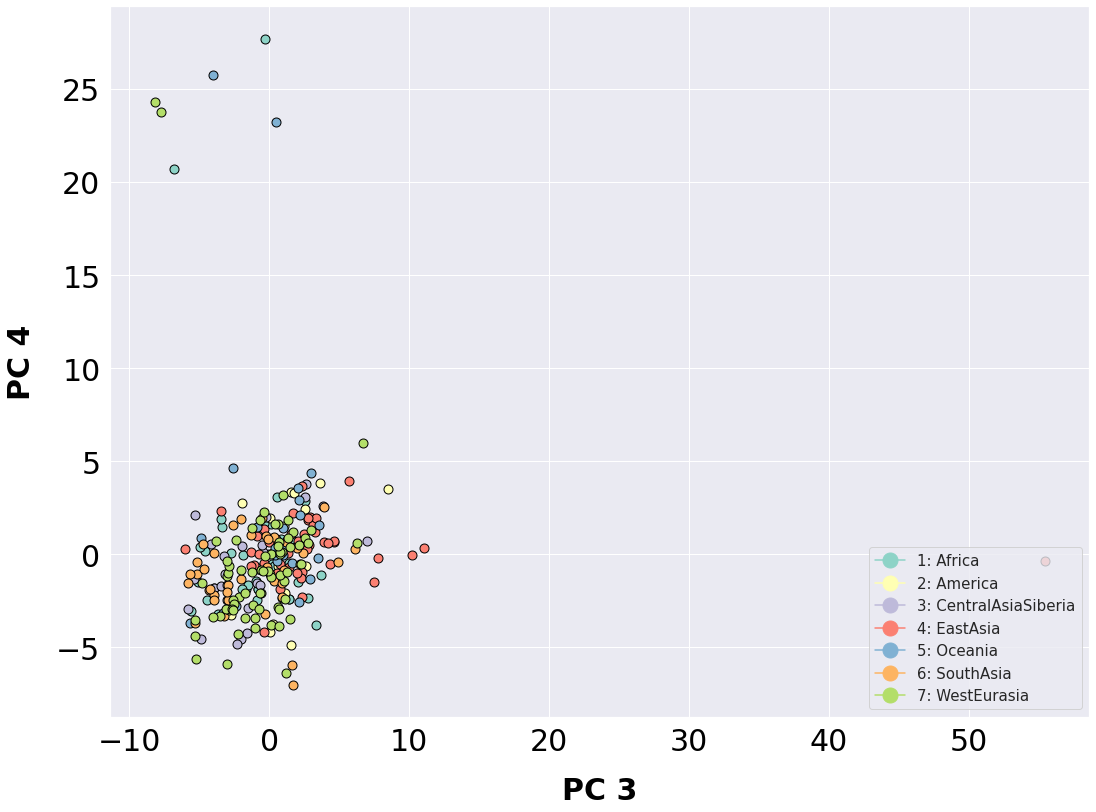

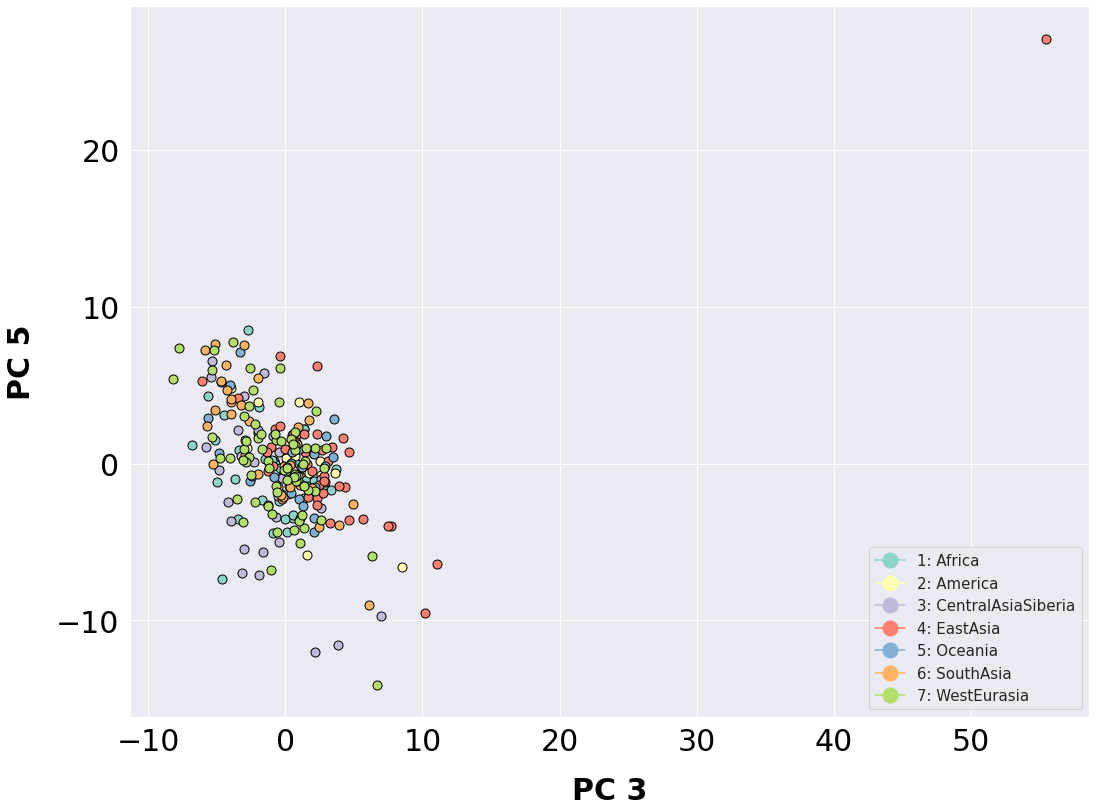

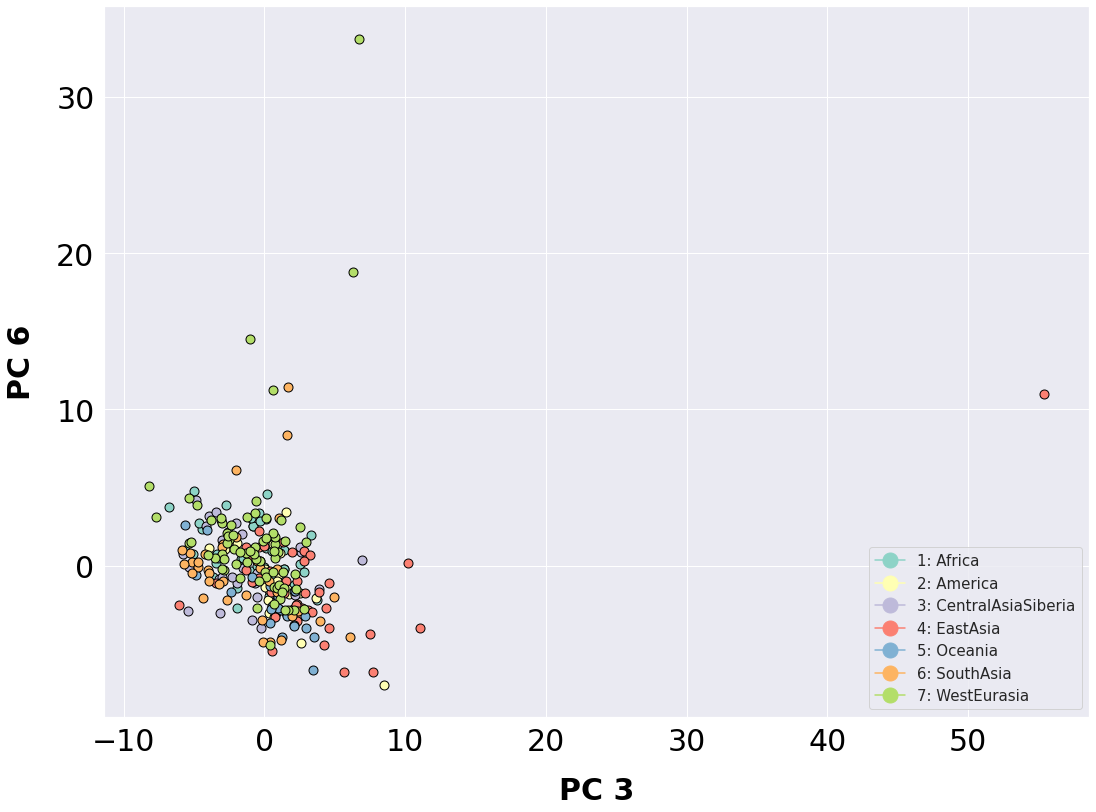

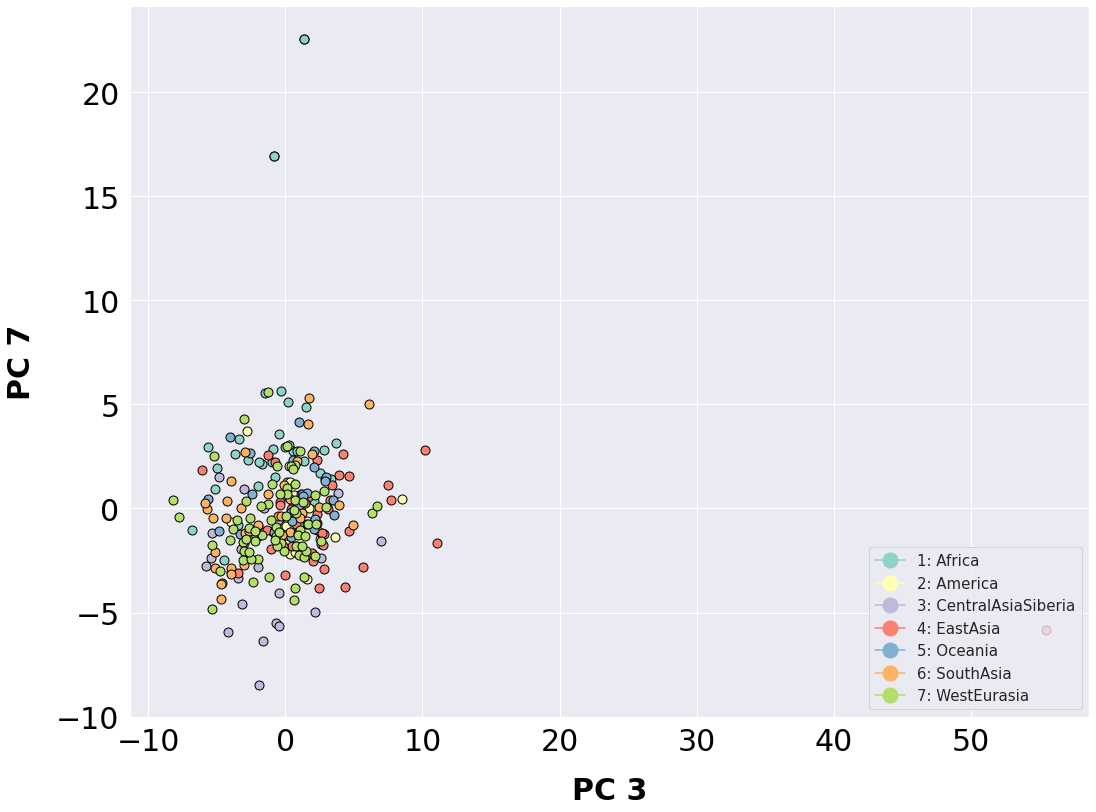

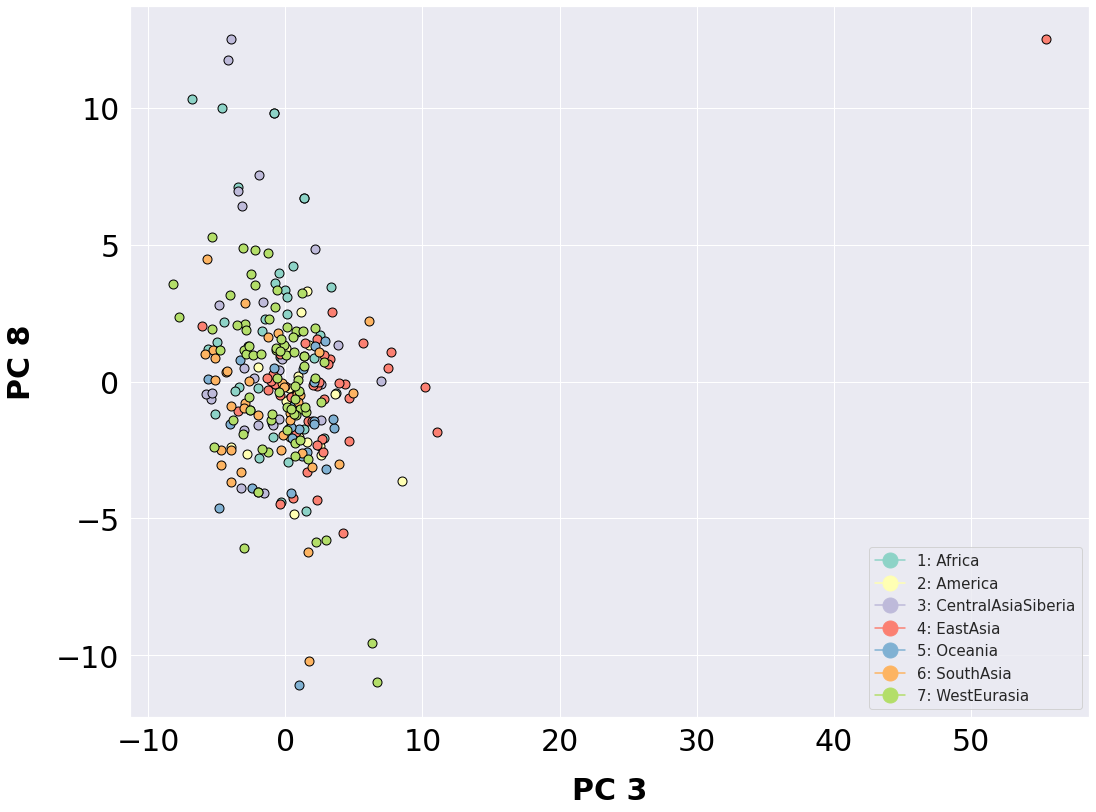

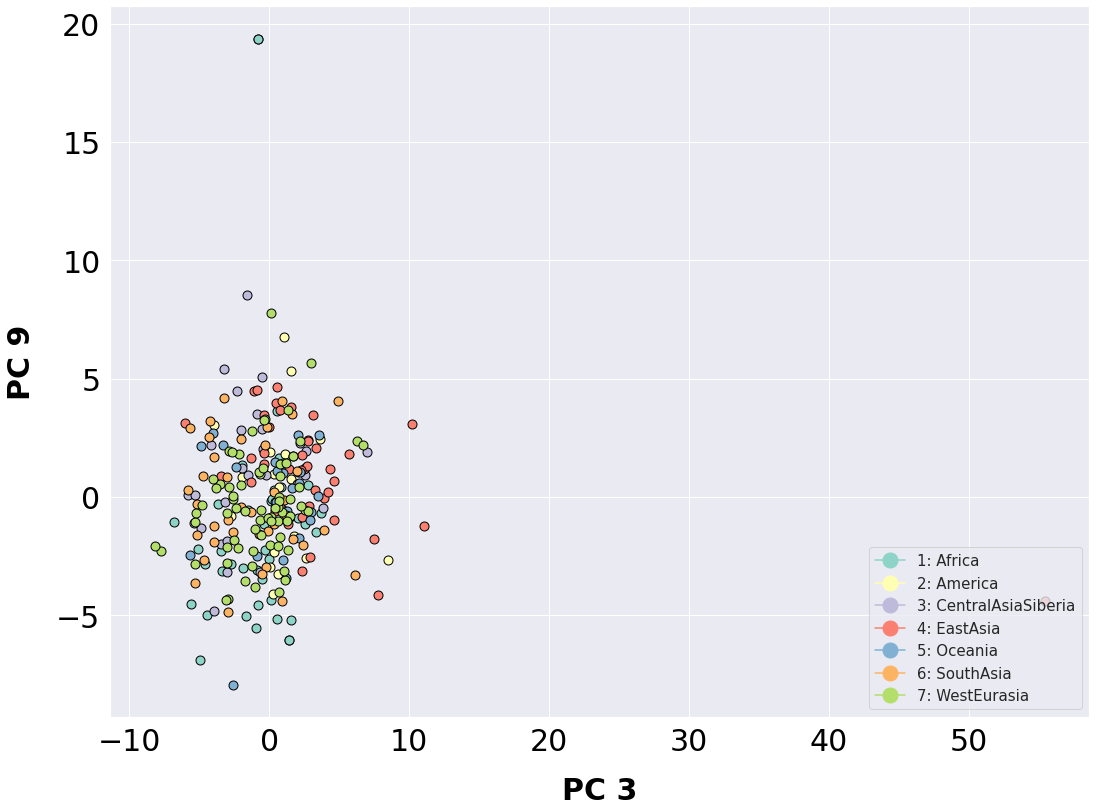

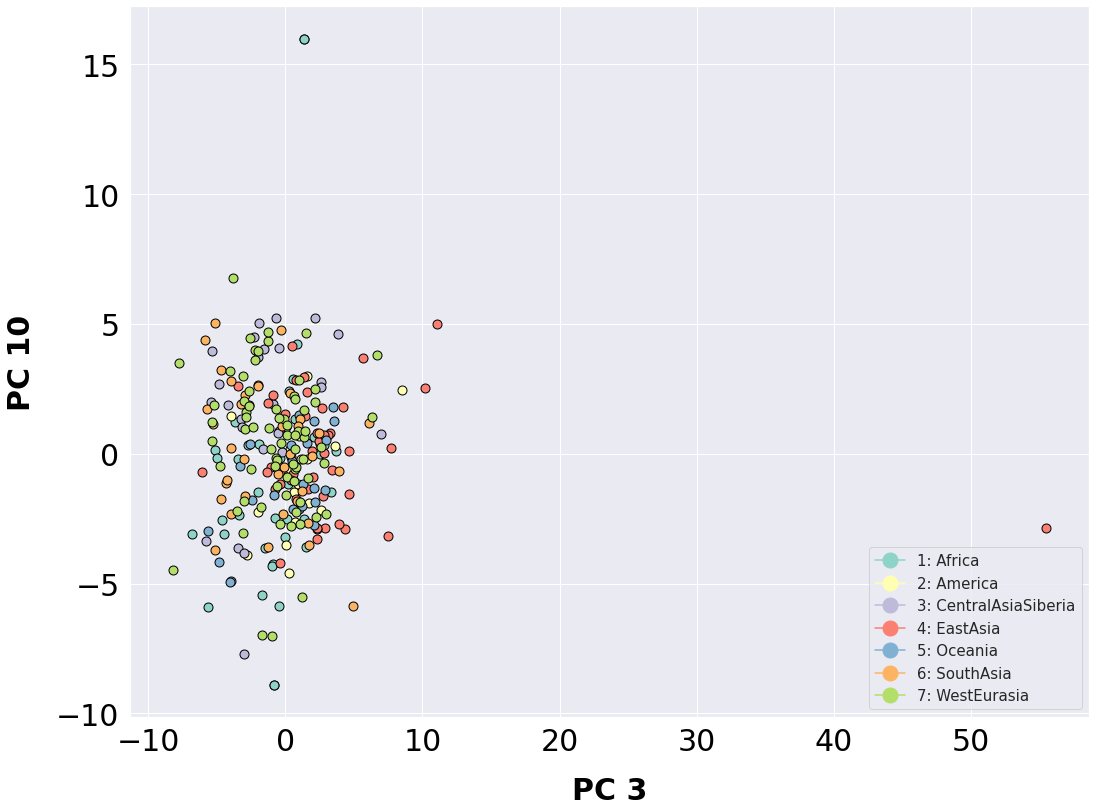

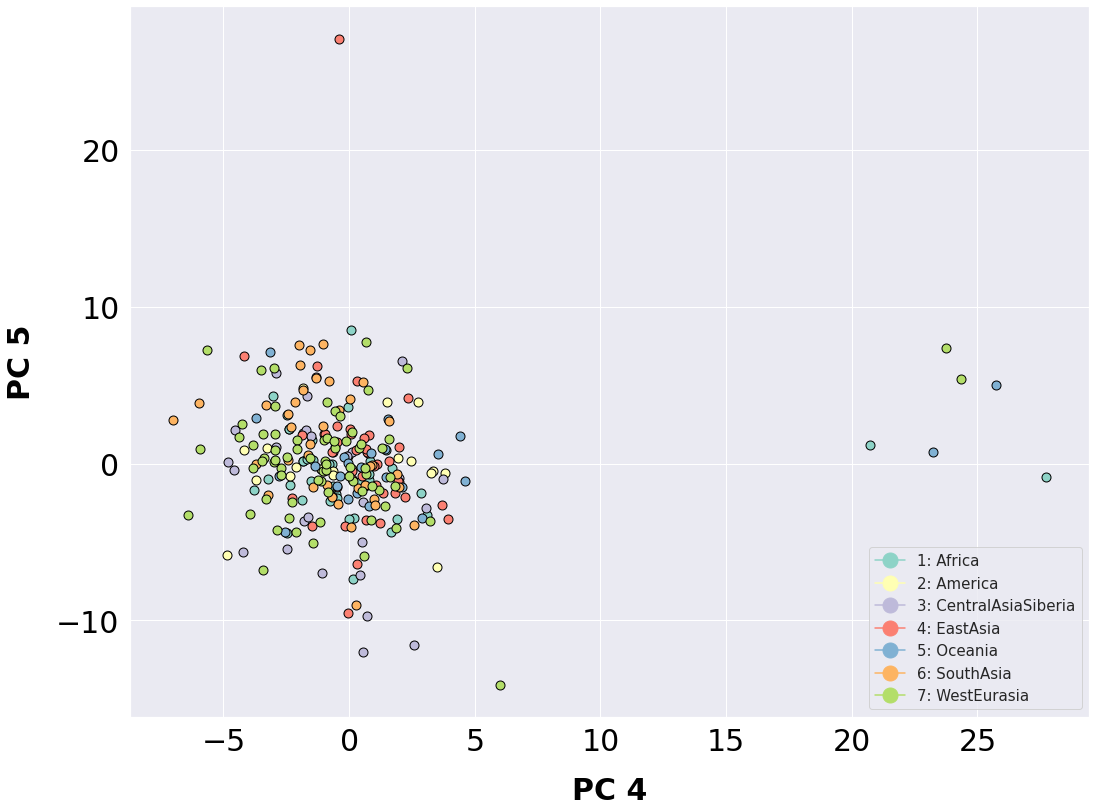

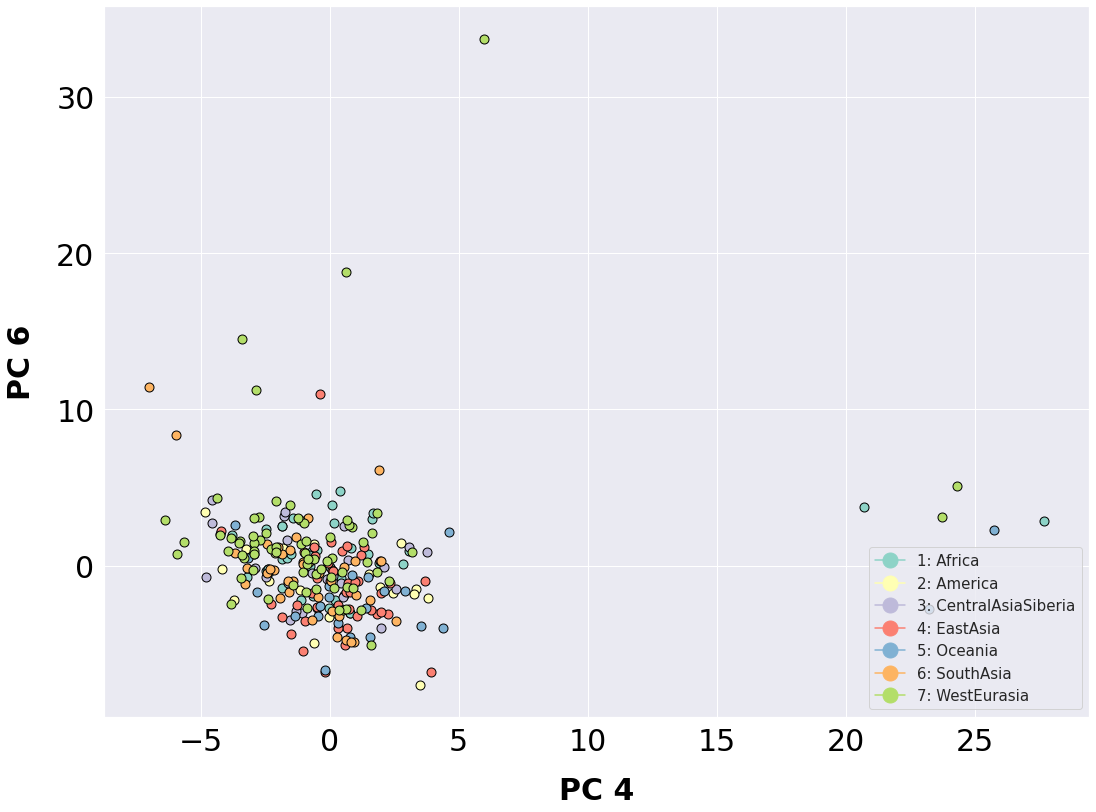

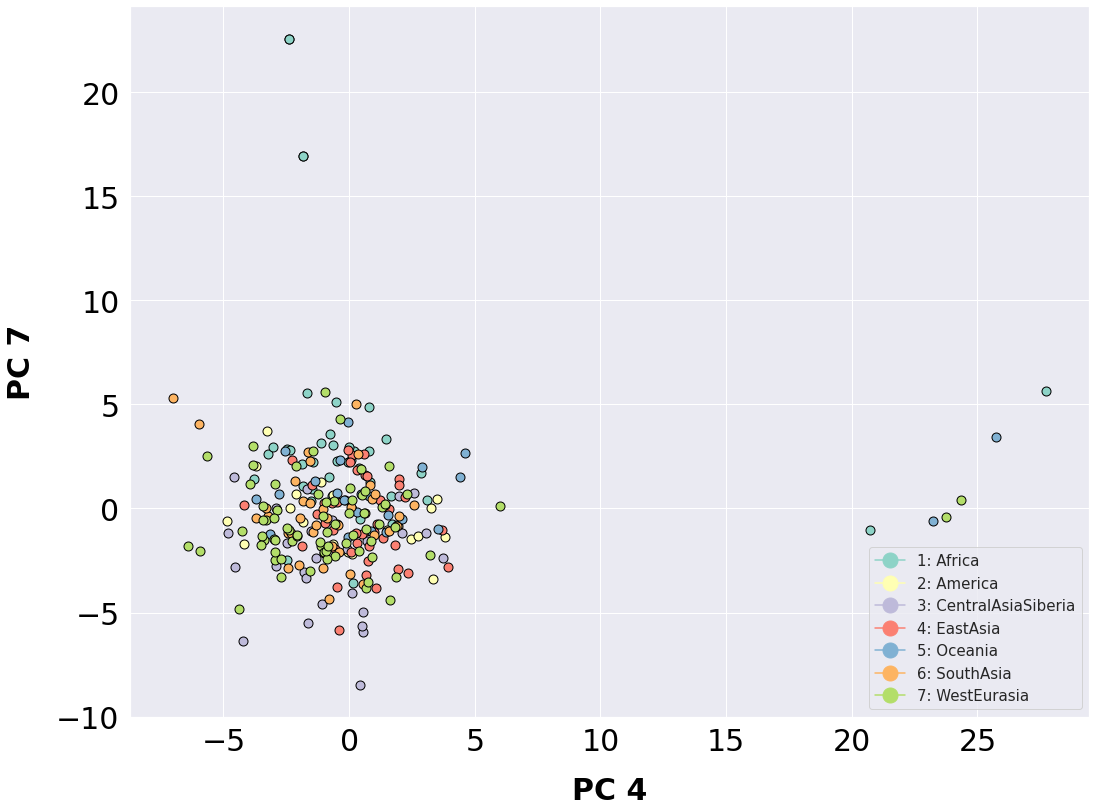

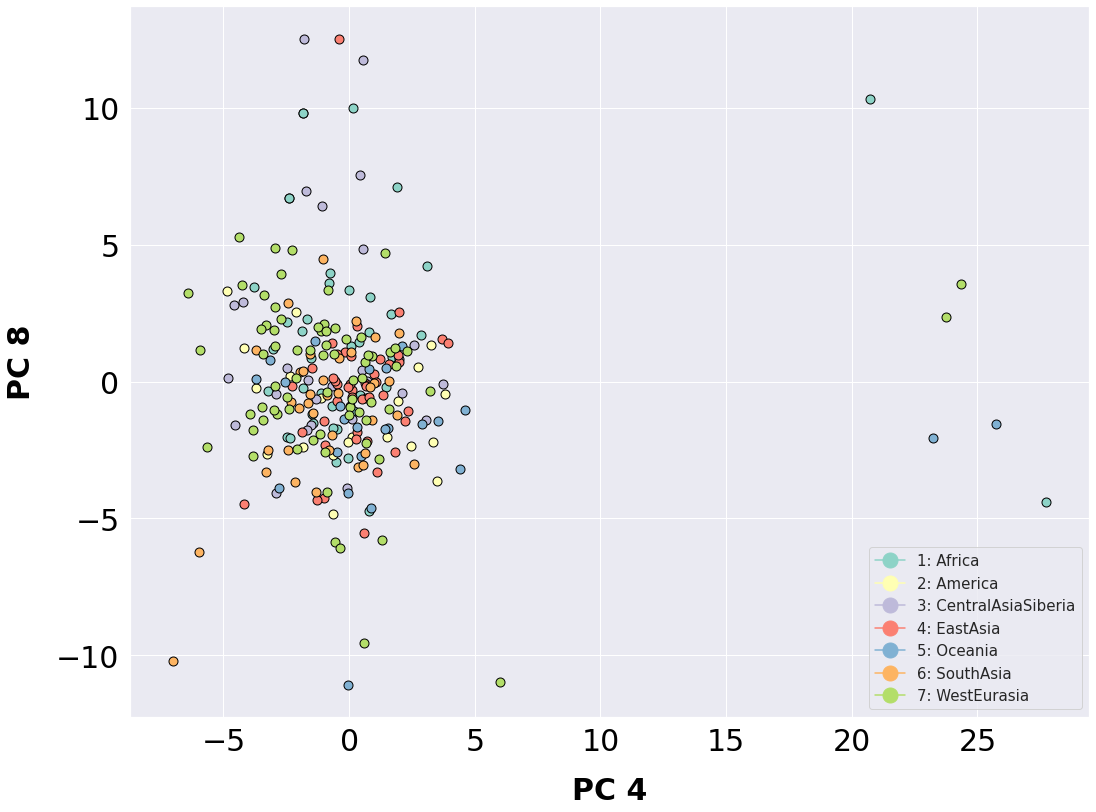

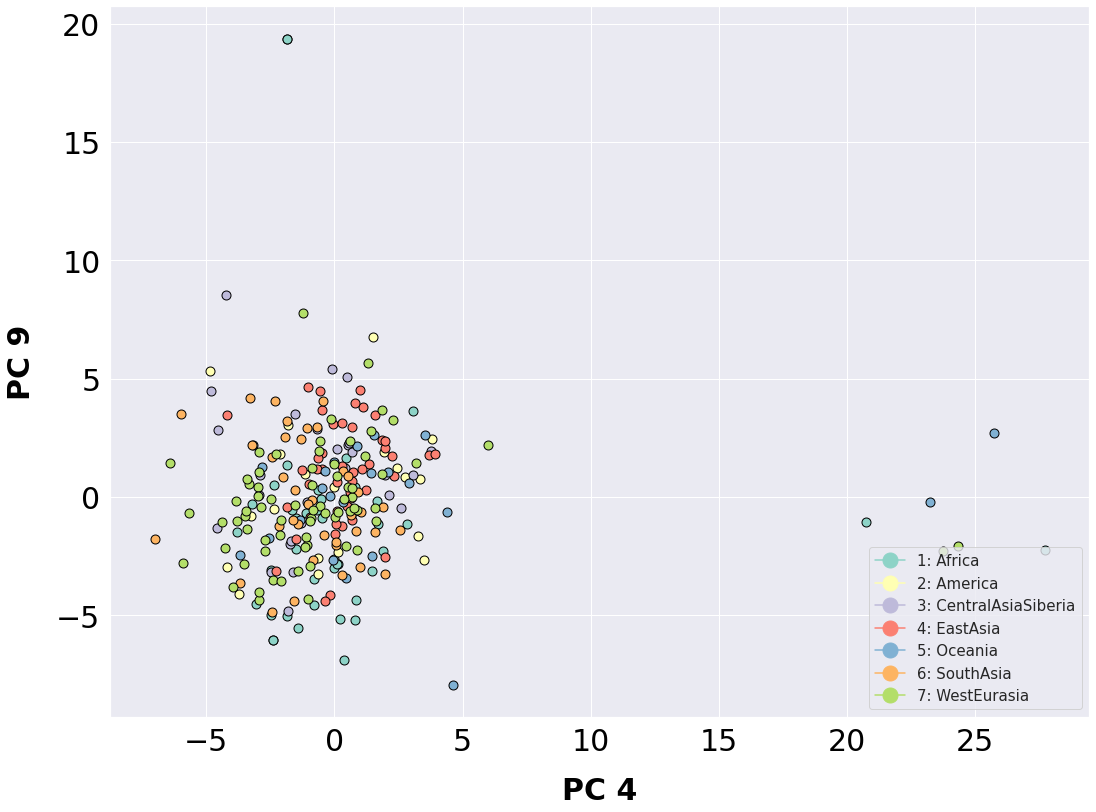

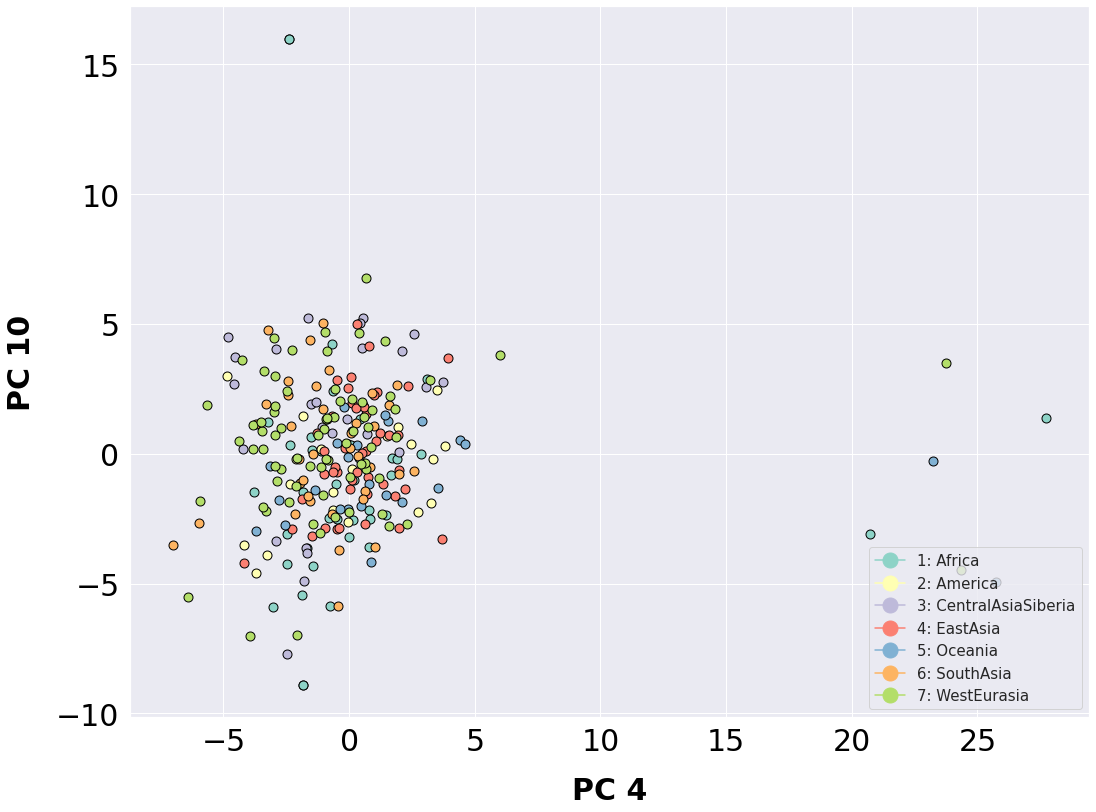

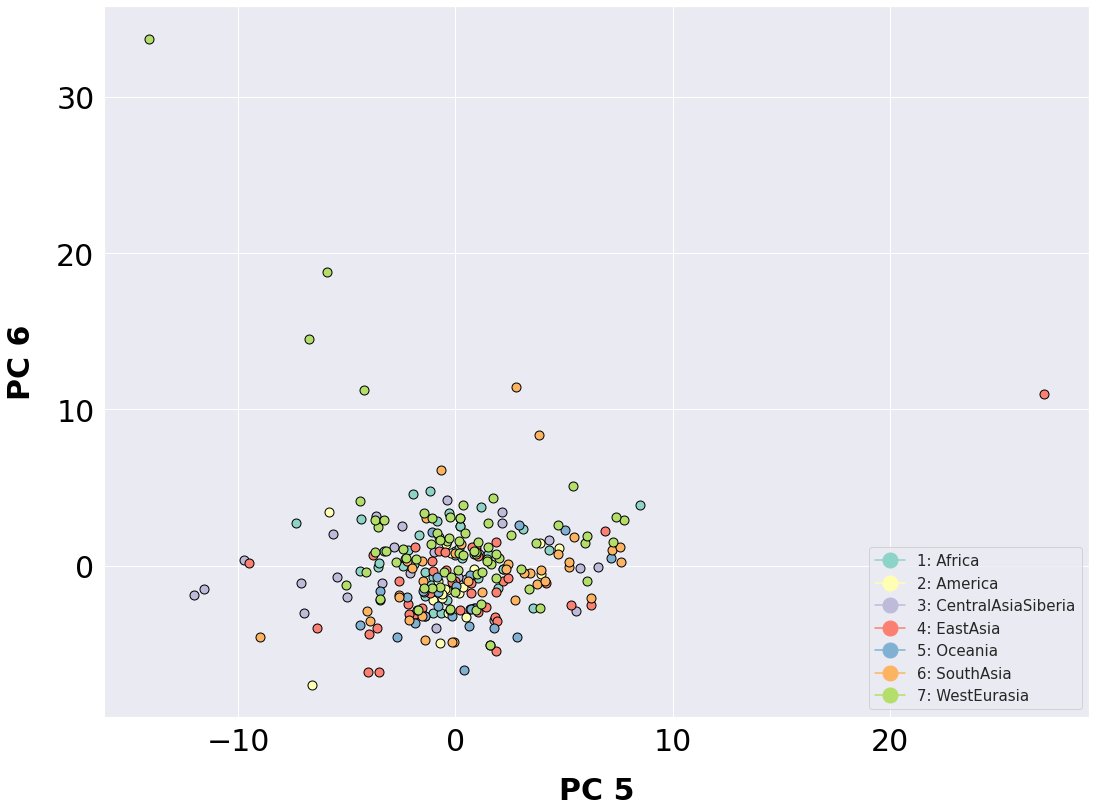

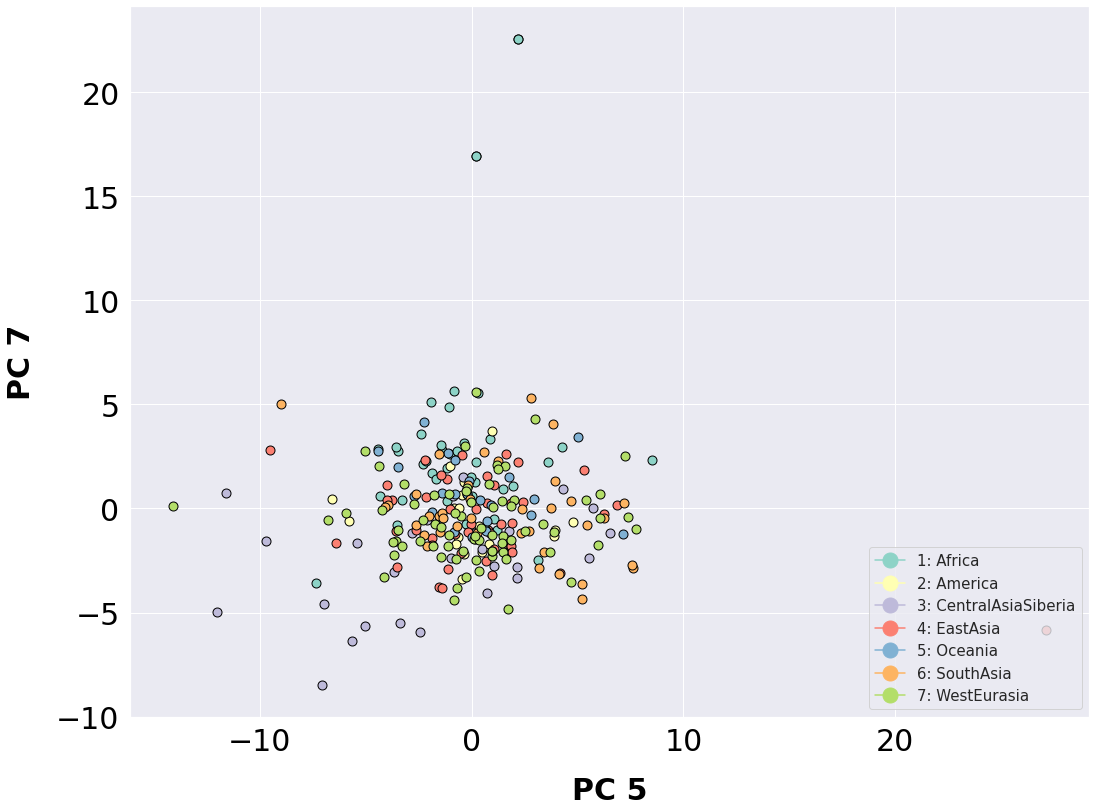

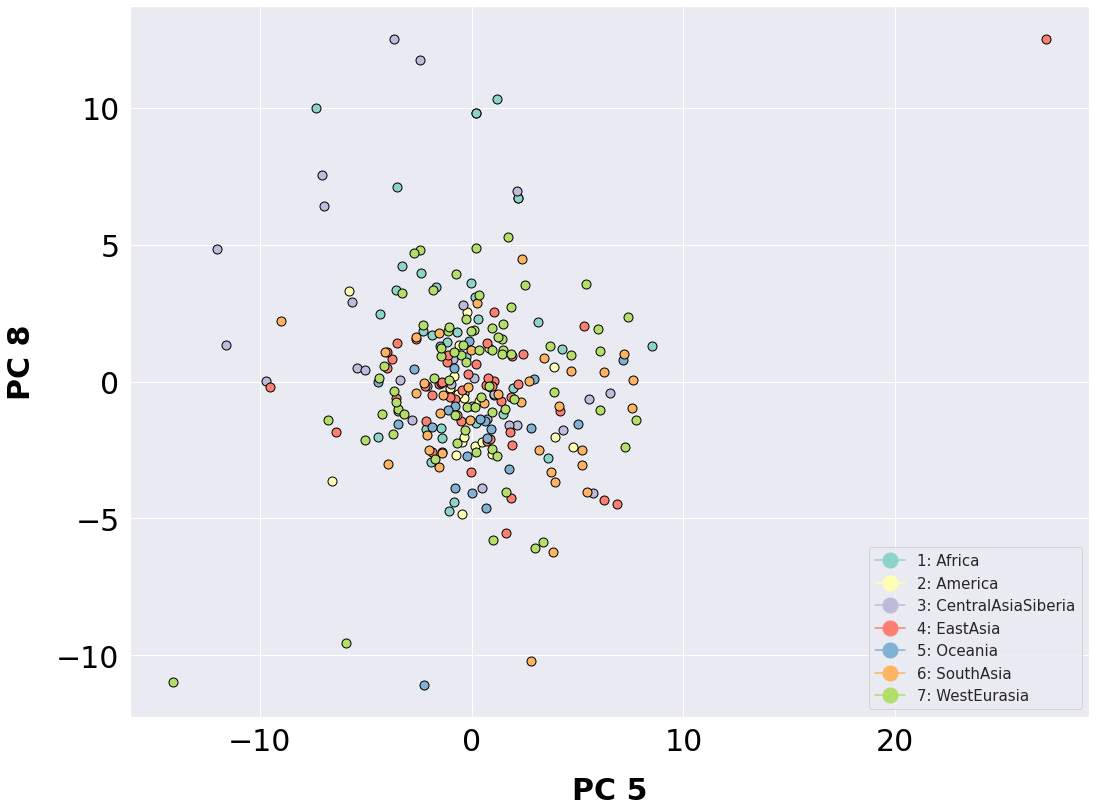

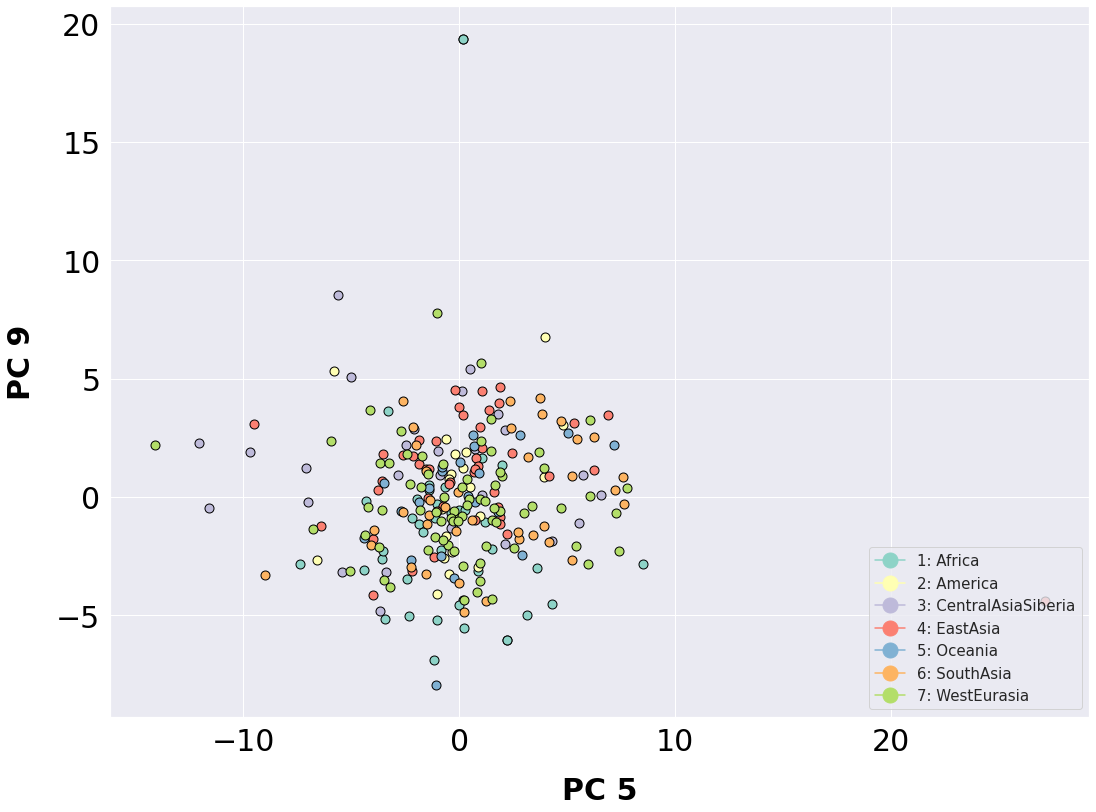

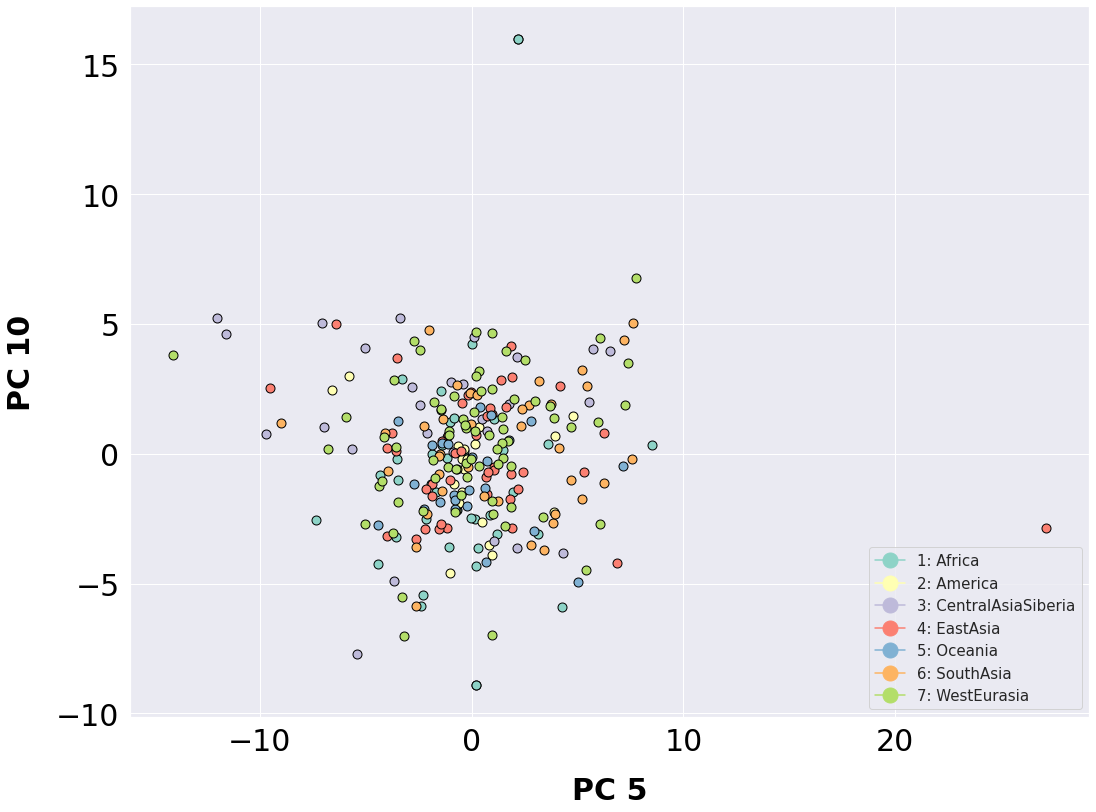

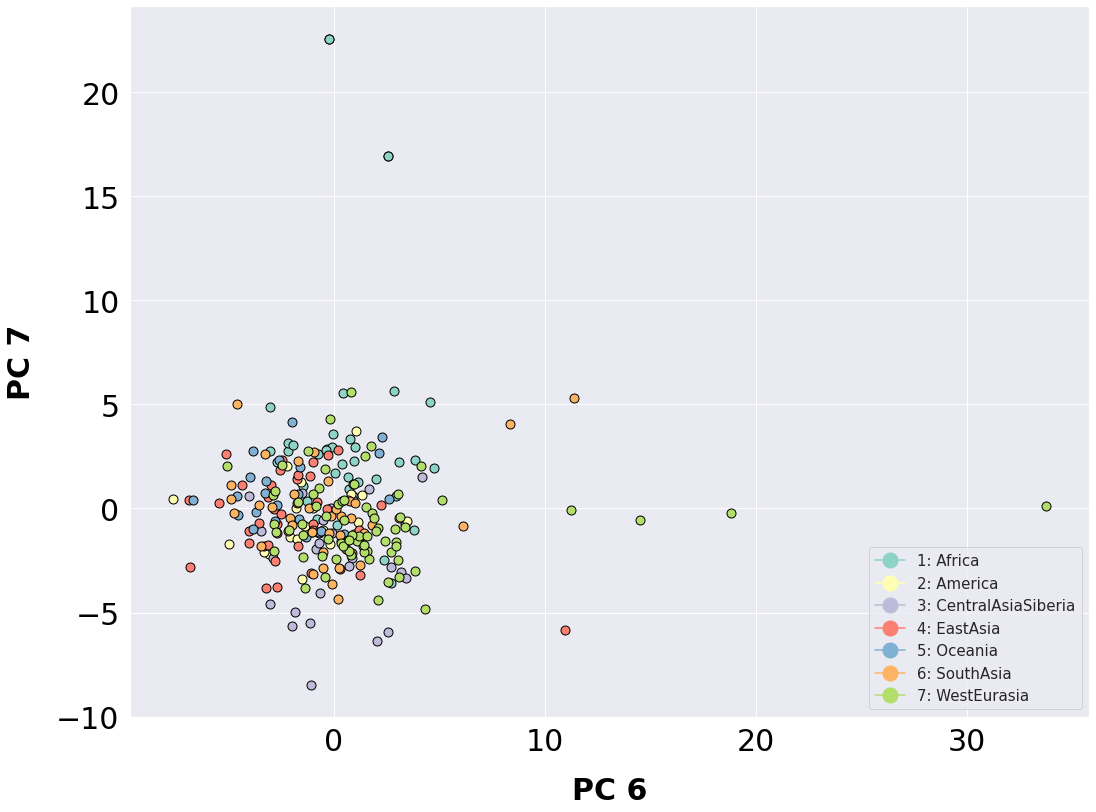

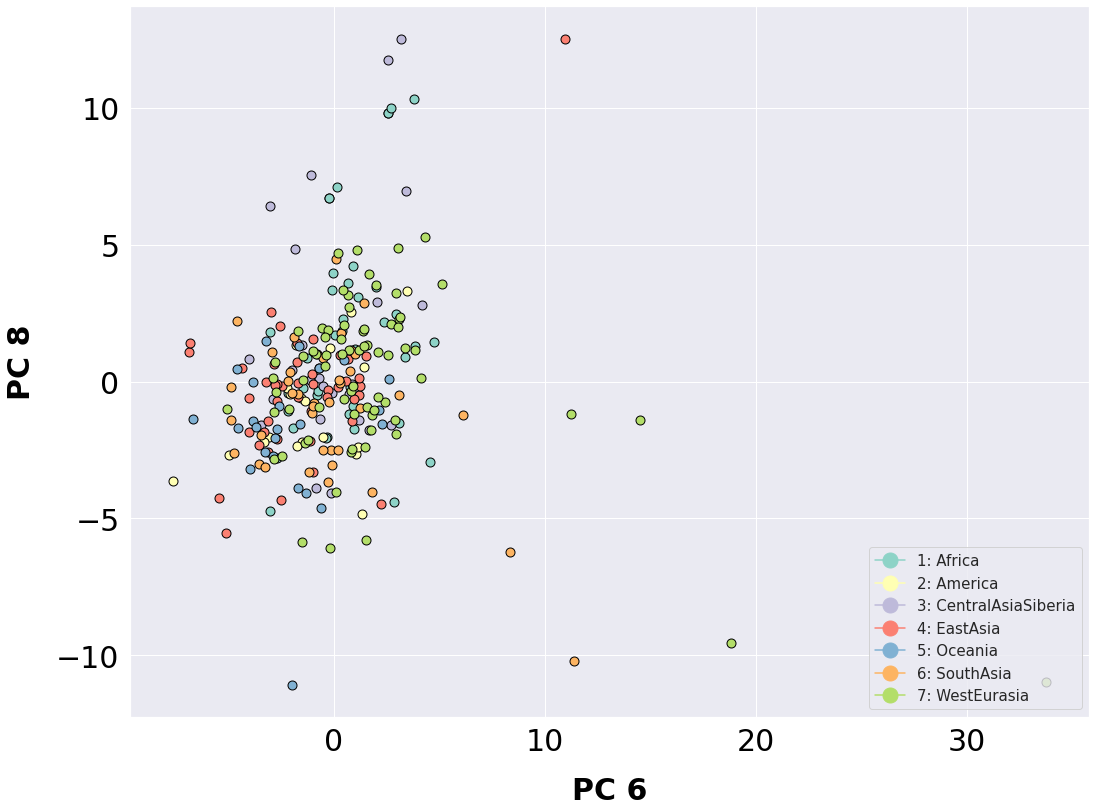

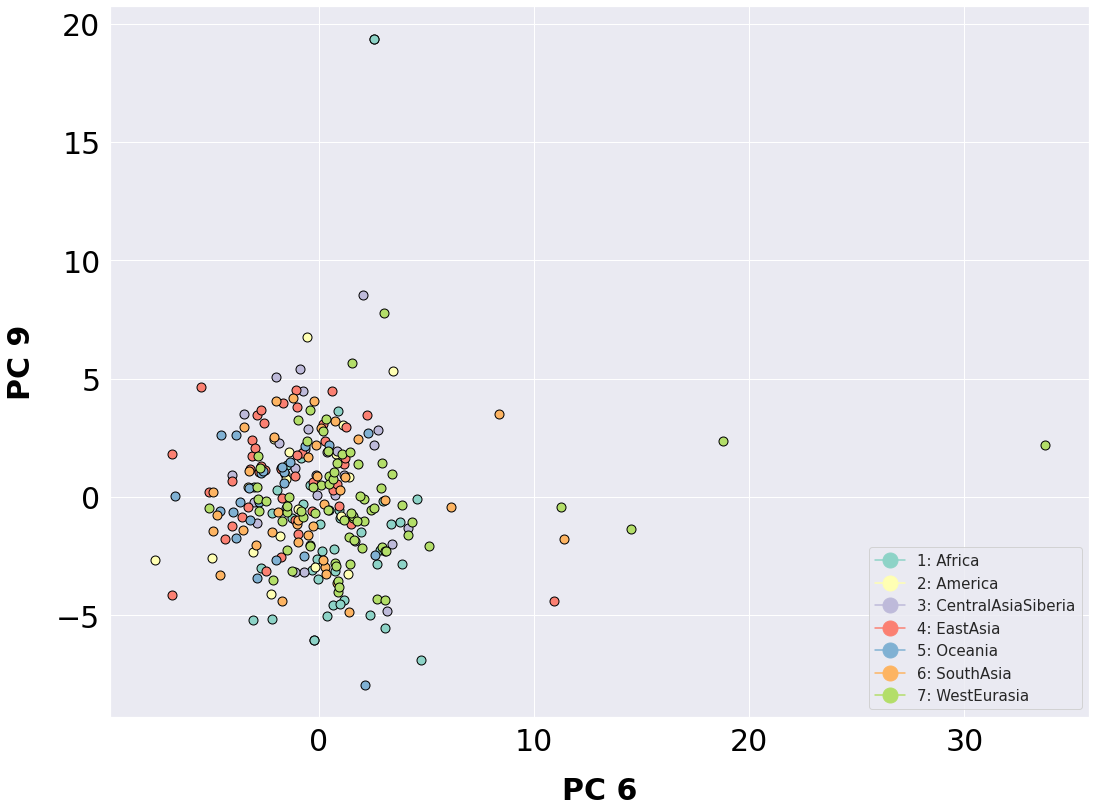

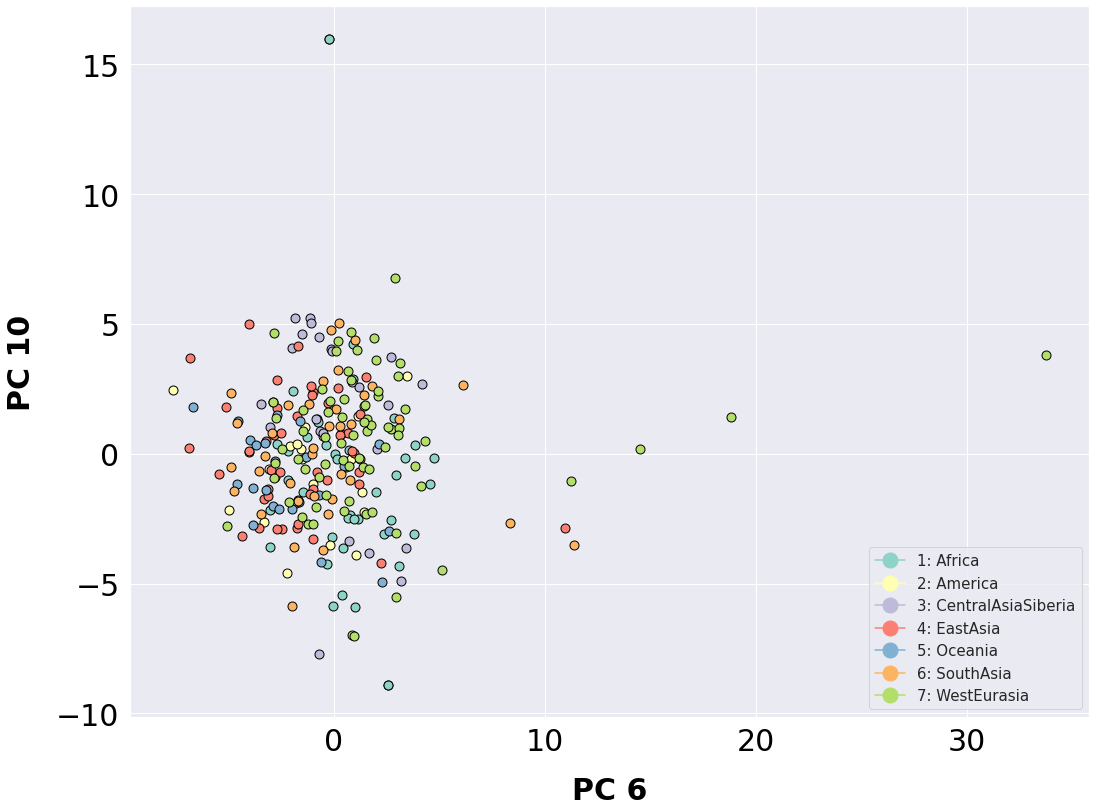

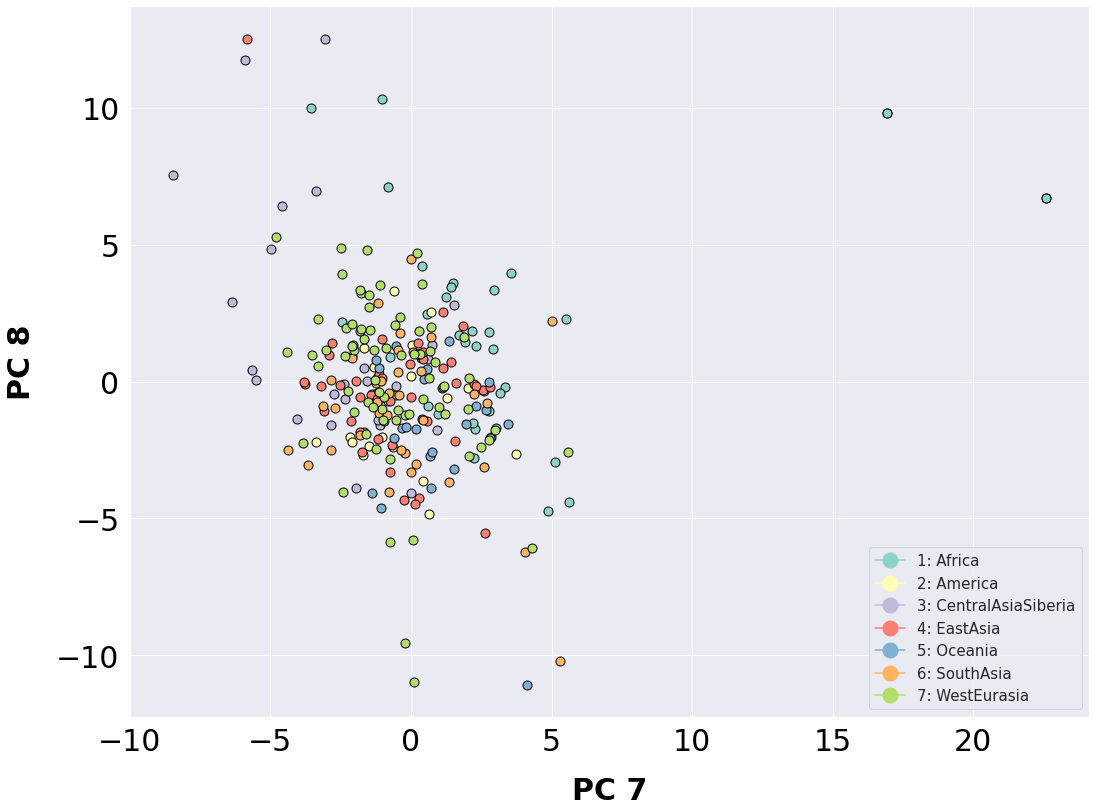

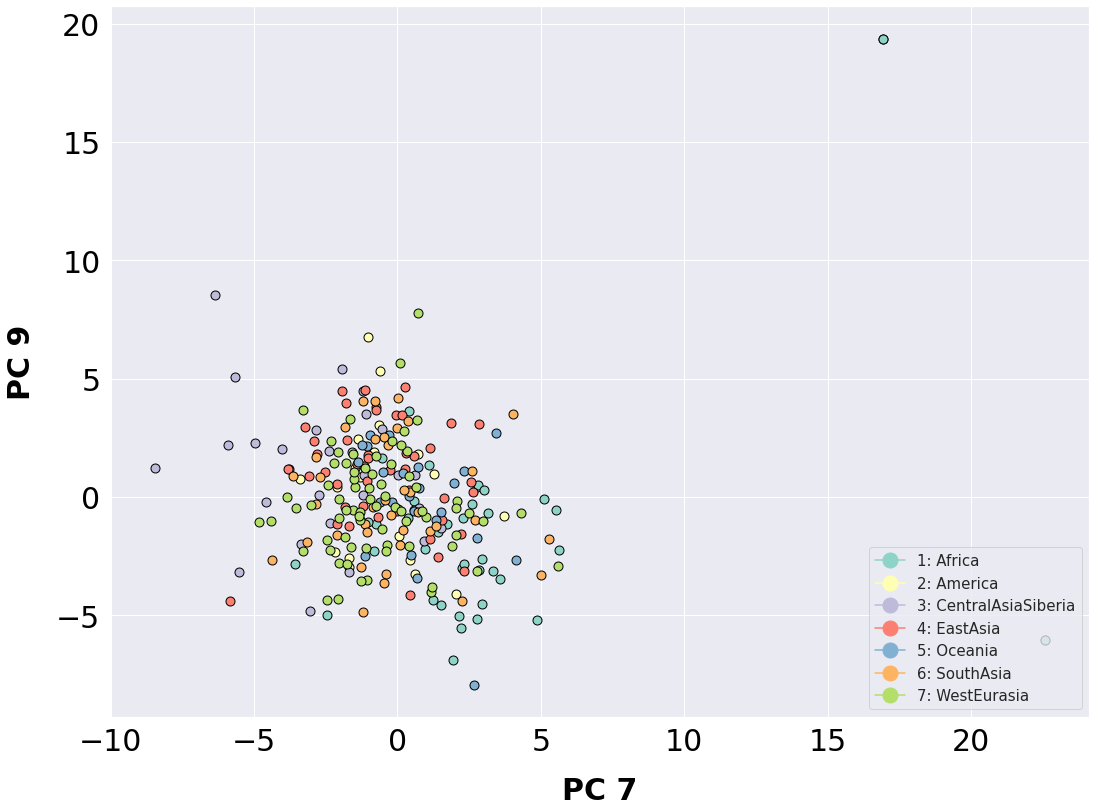

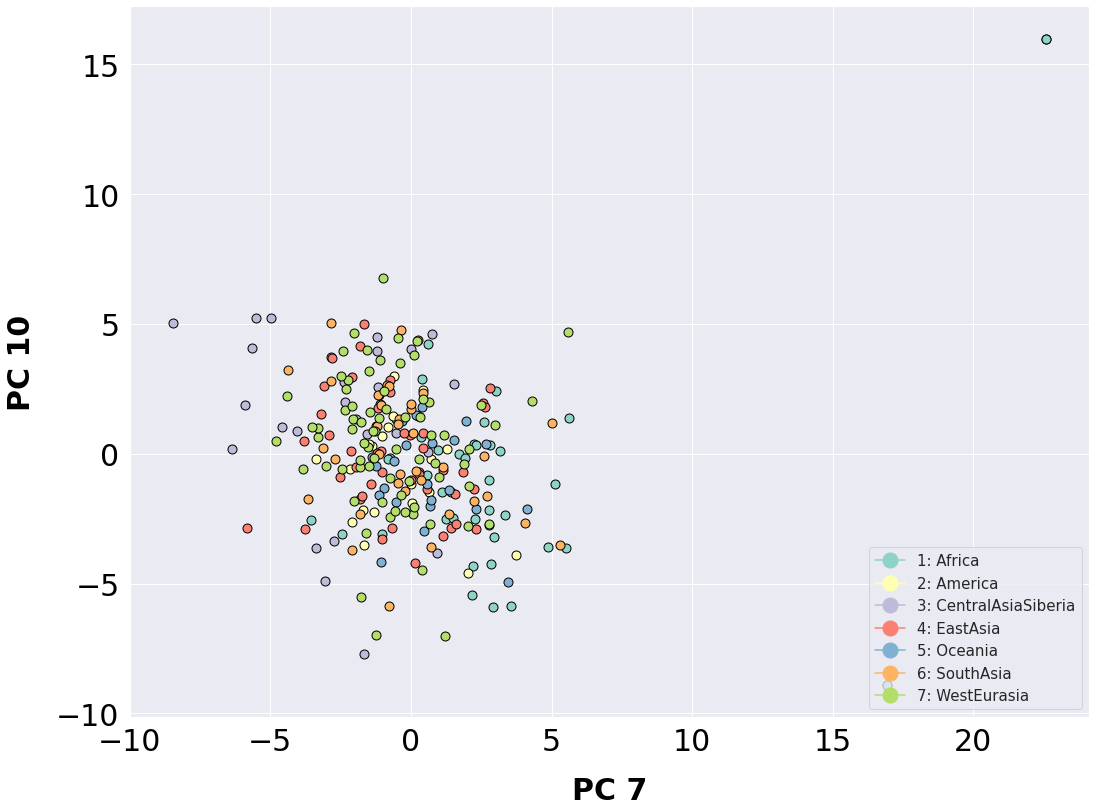

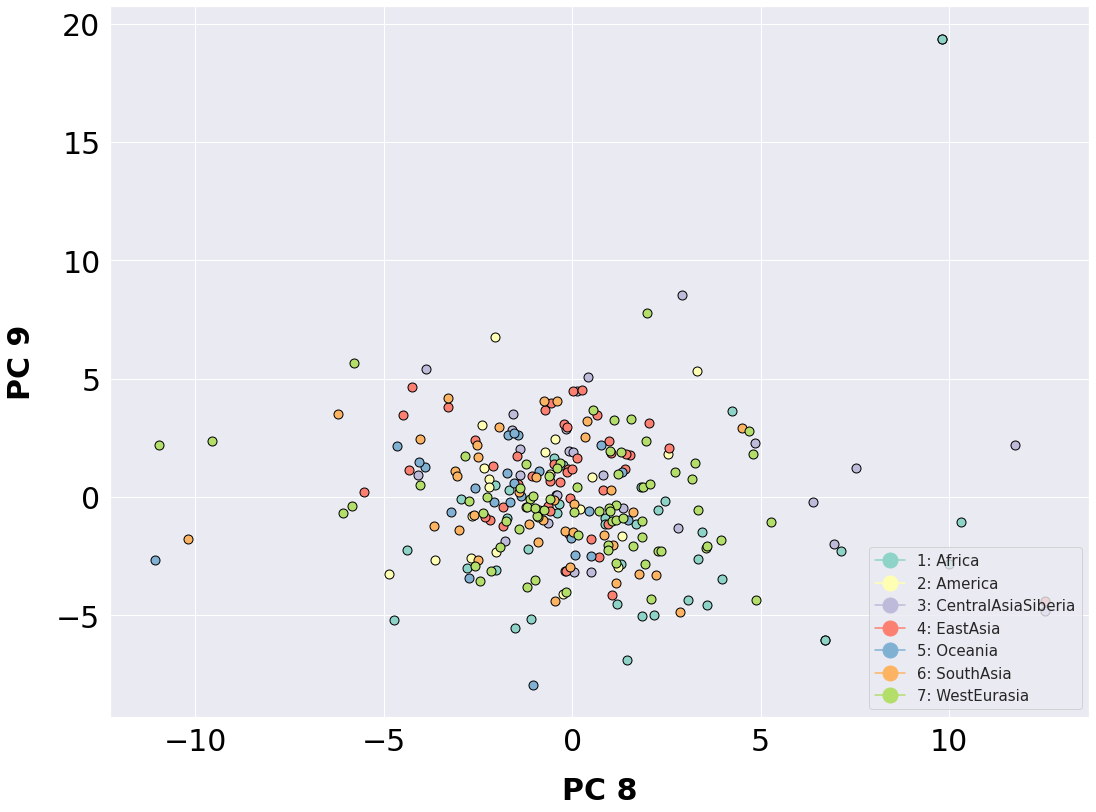

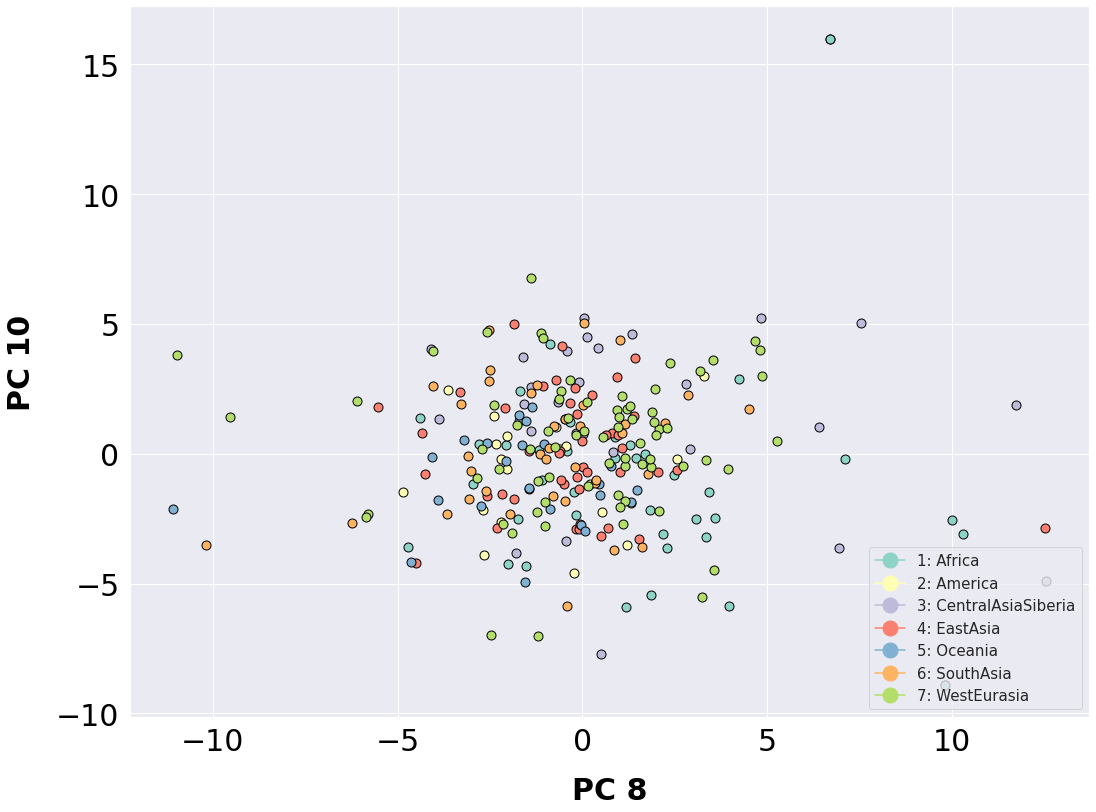

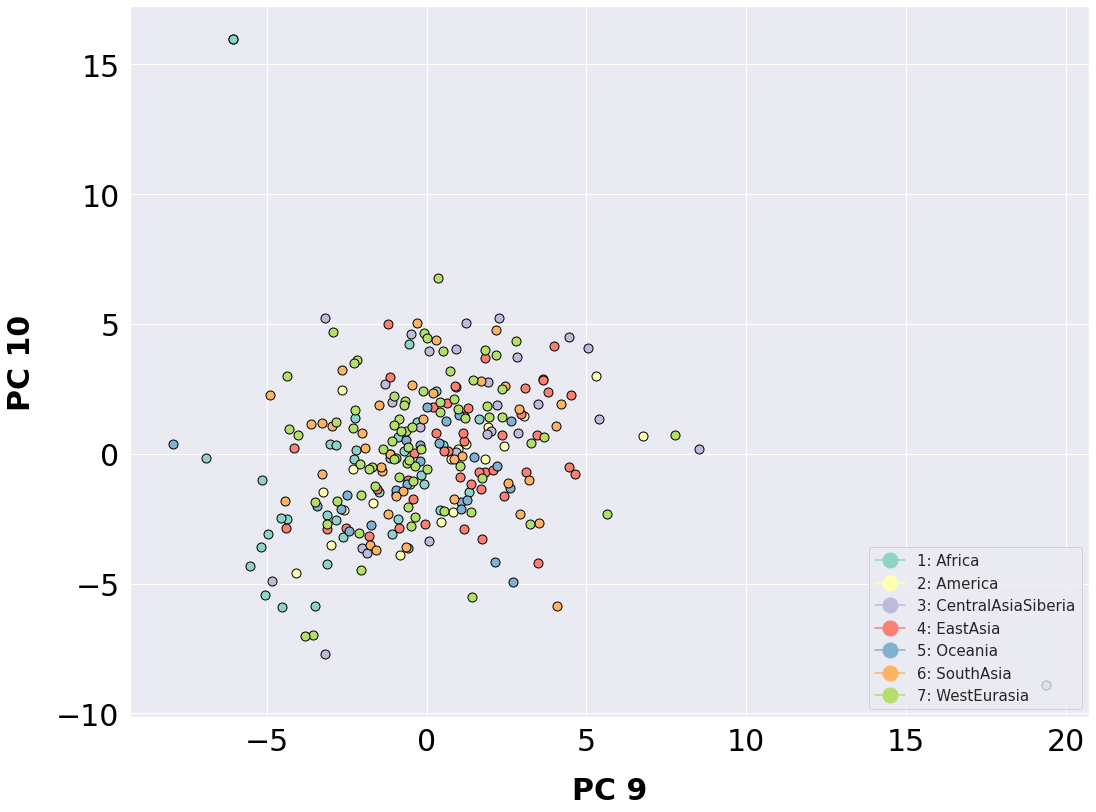

In [44]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

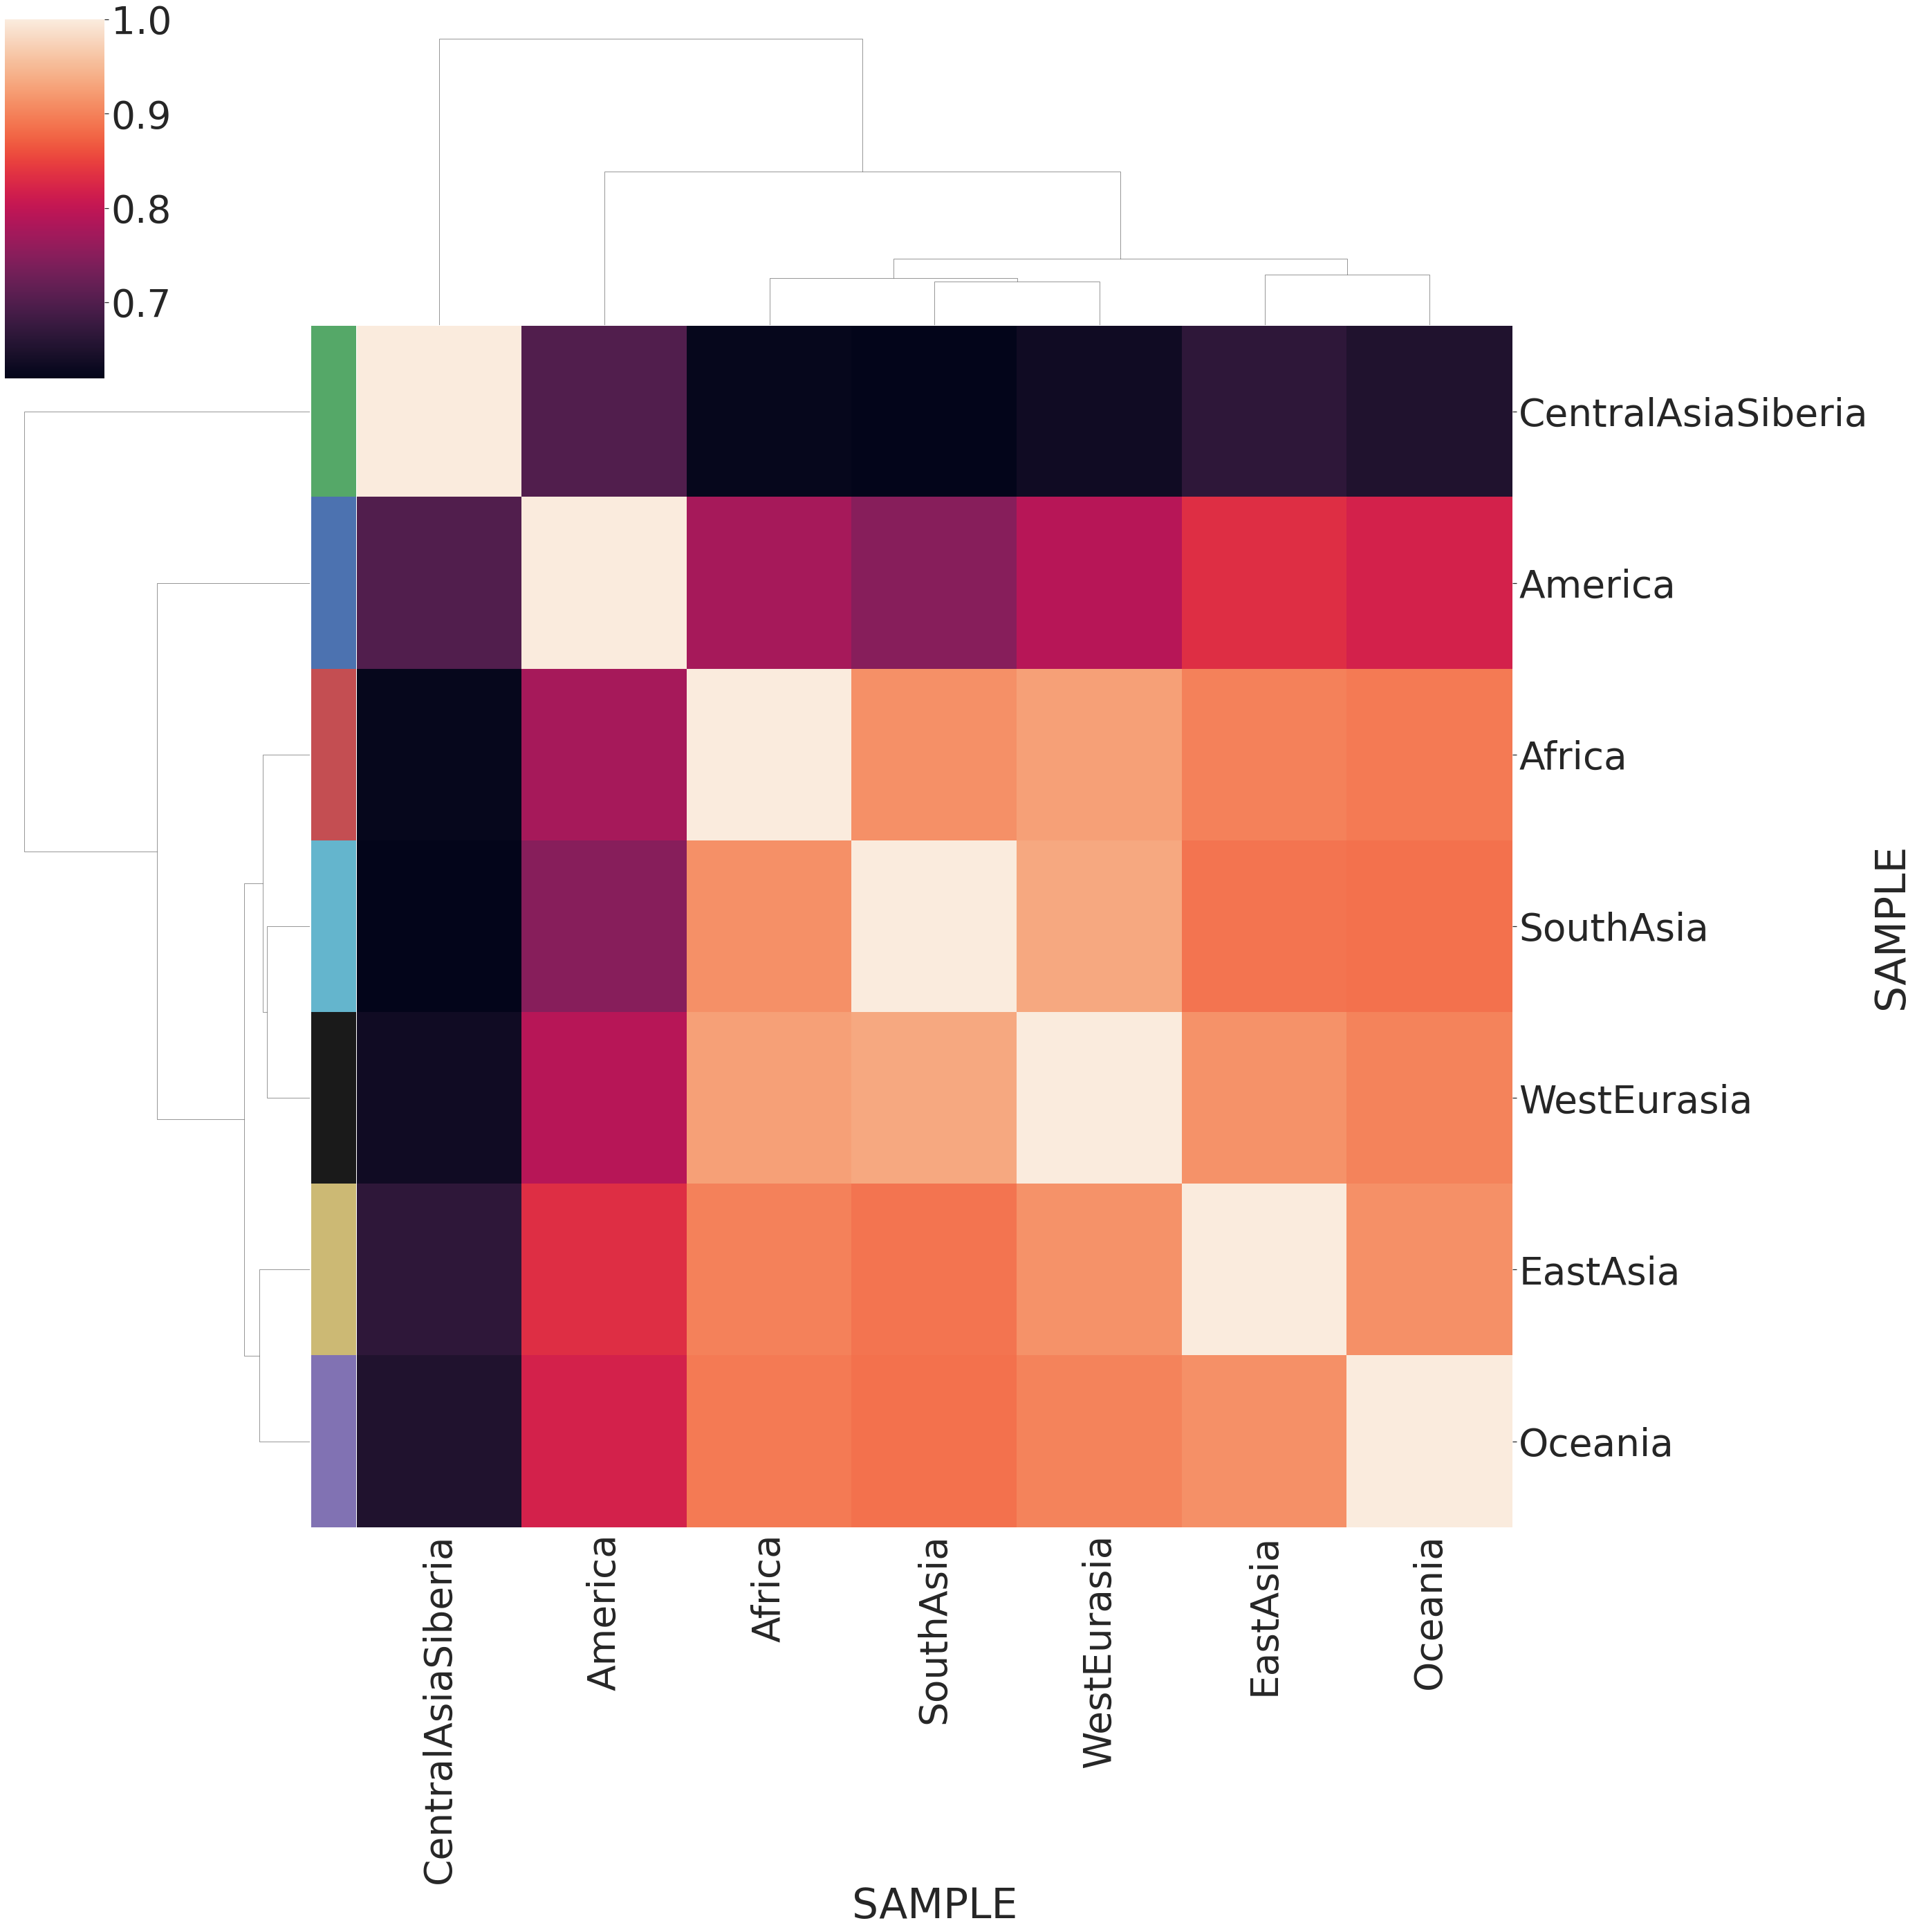

In [45]:
freq = final_cnv.iloc[:,3:283]
freq_input = freq.rename(columns=features['REGION'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

lut = dict(zip(df.columns.unique(), "rbgymck"))
lut

seaborn.set(font_scale=5)
corrmatrix = df.corr(method='spearman')
row_colors = df.columns.map(lut)
seaborn.clustermap(corrmatrix, row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.savefig('clustermap_regions.pdf')

In [46]:
feature_table = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [47]:
chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
chm13_gene_anotation


# feature                   class         assembly     assembly_unit  \
0           gene          protein_coding  GCF_009914755.1  Primary Assembly   
1           mRNA                     NaN  GCF_009914755.1  Primary Assembly   
2            CDS            with_protein  GCF_009914755.1  Primary Assembly   
3           gene                  lncRNA  GCF_009914755.1  Primary Assembly   
4          ncRNA                  lncRNA  GCF_009914755.1  Primary Assembly   
...          ...                     ...              ...               ...   
236307      gene          protein_coding  GCF_009914755.1  Primary Assembly   
236308      mRNA                     NaN  GCF_009914755.1  Primary Assembly   
236309       CDS            with_protein  GCF_009914755.1  Primary Assembly   
236310      gene  transcribed_pseudogene  GCF_009914755.1  Primary Assembly   
236311  misc_RNA                     NaN  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
1       chromosome          1       NC_060925.1     11134     37628      -   
2       chromosome          1       NC_060925.1     13463     37628      -   
3       chromosome          1       NC_060925.1     20892     23710      -   
4       chromosome          1       NC_060925.1     20892     23710      -   
...            ...        ...               ...       ...       ...    ...   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   
236308  chromosome          Y       NC_060948.1  62446549  62449392      +   
236309  chromosome          Y       NC_060948.1  62446549  62449100      +   
236310  chromosome          Y       NC_060948.1  62449384  62451910      -   
236311  chromosome          Y       NC_060948.1  62449384  62451910      -   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
1       ...             1  assembled-molecule                 1   
2       ...             1  assembled-molecule                 1   
3       ...             1  assembled-molecule                 1   
4       ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
236307  ...             Y  assembled-molecule                 Y   
236308  ...             Y  assembled-molecule                 Y   
236309  ...             Y  assembled-molecule                 Y   
236310  ...             Y  assembled-molecule                 Y   
236311  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
1                           Chromosome   CP068277.2             =   
2                           Chromosome   CP068277.2             =   
3                           Chromosome   CP068277.2             =   
4                           Chromosome   CP068277.2             =   
...                                ...          ...           ...   
236307                      Chromosome   CP086569.2             =   
236308                      Chromosome   CP086569.2             =   
236309                      Chromosome   CP086569.2             =   
236310                      Chromosome   CP086569.2             =   
236311                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
1       NC_060925.1  Primary Assembly        248387328              na  
2       NC_060925.1  Primary Assembly        248387328              na  
3       NC_060925.1  Primary Assembly        248387328              na  
4       NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...            

<h1> Phylo

In [49]:
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
import scipy.stats

a = scipy.stats.zscore(counts, axis=1)
distances = pdist(np.array(a), metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix.shape

dist_matrix

name =  list(counts.index)
matrix = dist_matrix
dist_matrix

array([[ 0.        , 61.7586102 , 59.97977364, ..., 43.71434175,
        64.30611695, 43.27677971],
       [61.7586102 ,  0.        , 39.80170135, ..., 61.01180382,
        43.42342429, 63.34235705],
       [59.97977364, 39.80170135,  0.        , ..., 60.53128602,
        43.25351629, 61.75839062],
       ...,
       [43.71434175, 61.01180382, 60.53128602, ...,  0.        ,
        57.40194539, 41.84723944],
       [64.30611695, 43.42342429, 43.25351629, ..., 57.40194539,
         0.        , 60.05437403],
       [43.27677971, 63.34235705, 61.75839062, ..., 41.84723944,
        60.05437403,  0.        ]])

In [50]:
lut = dict(zip(features['REGION'].unique(), "rbgymck"))

row_colors = features['REGION'].map(lut)
row_color = row_colors.to_dict()
lut

features

REGION           COUNTRY
SAMPLE                                          
LP6005441-DNA_A01  WestEurasia  Russia(Caucasus)
LP6005441-DNA_A03      Oceania    PapuaNewGuinea
LP6005441-DNA_A04      America          Colombia
LP6005441-DNA_A05  WestEurasia            France
LP6005441-DNA_A06  WestEurasia    Italy(Bergamo)
...                        ...               ...
LP6007069-DNA_A01  WestEurasia            Greece
SS6004471               Africa             Congo
SS6004477              Oceania         Australia
SS6004478              Oceania         Australia
SS6004480               Africa             Sudan

[269 rows x 2 columns]

In [51]:
from biotite.sequence.phylo import neighbor_joining
#track features for pca & tsne
#features = features.sort_index()

#names.get_indices()
labels = list(counts.index)
#labels = list(features['10-Region'])
tree = biotite.sequence.phylo.neighbor_joining(dist_matrix)
t = print(tree.to_newick(labels=labels, include_distance=True))


#with open('newick_tree.tree', 'a') as f:
#    f.write(t)


(((((((((((LP6005677-DNA_E01:16.68612289428711,LP6005443-DNA_C07:16.882469177246094):0.5558064579963684,(LP6005441-DNA_C03:18.20403289794922,LP6005441-DNA_B11:17.56969451904297):0.43260258436203003):0.15110456943511963,((LP6005443-DNA_F08:17.000076293945312,LP6005443-DNA_F07:15.838297843933105):0.8409658670425415,(LP6005443-DNA_C02:16.077810287475586,LP6005441-DNA_A01:17.962106704711914):0.32696282863616943):0.2642449140548706):0.09235411137342453,(((((((LP6005592-DNA_G03:19.34238624572754,LP6005442-DNA_E04:14.688619613647461):3.1248538494110107,(LP6005443-DNA_F10:13.62031078338623,LP6005443-DNA_E10:13.353087425231934):1.5609914064407349):1.6097381114959717,LP6005441-DNA_A05:16.0142822265625):0.1839112788438797,((((LP6005443-DNA_D06:15.010952949523926,LP6005443-DNA_D02:15.040234565734863):0.4174541234970093,LP6005441-DNA_E07:15.714553833007812):0.2777799963951111,LP6005441-DNA_G03:15.913132667541504):0.32986021041870117,(LP6005441-DNA_C07:14.645721435546875,LP6005441-DNA_C02:15.6346569

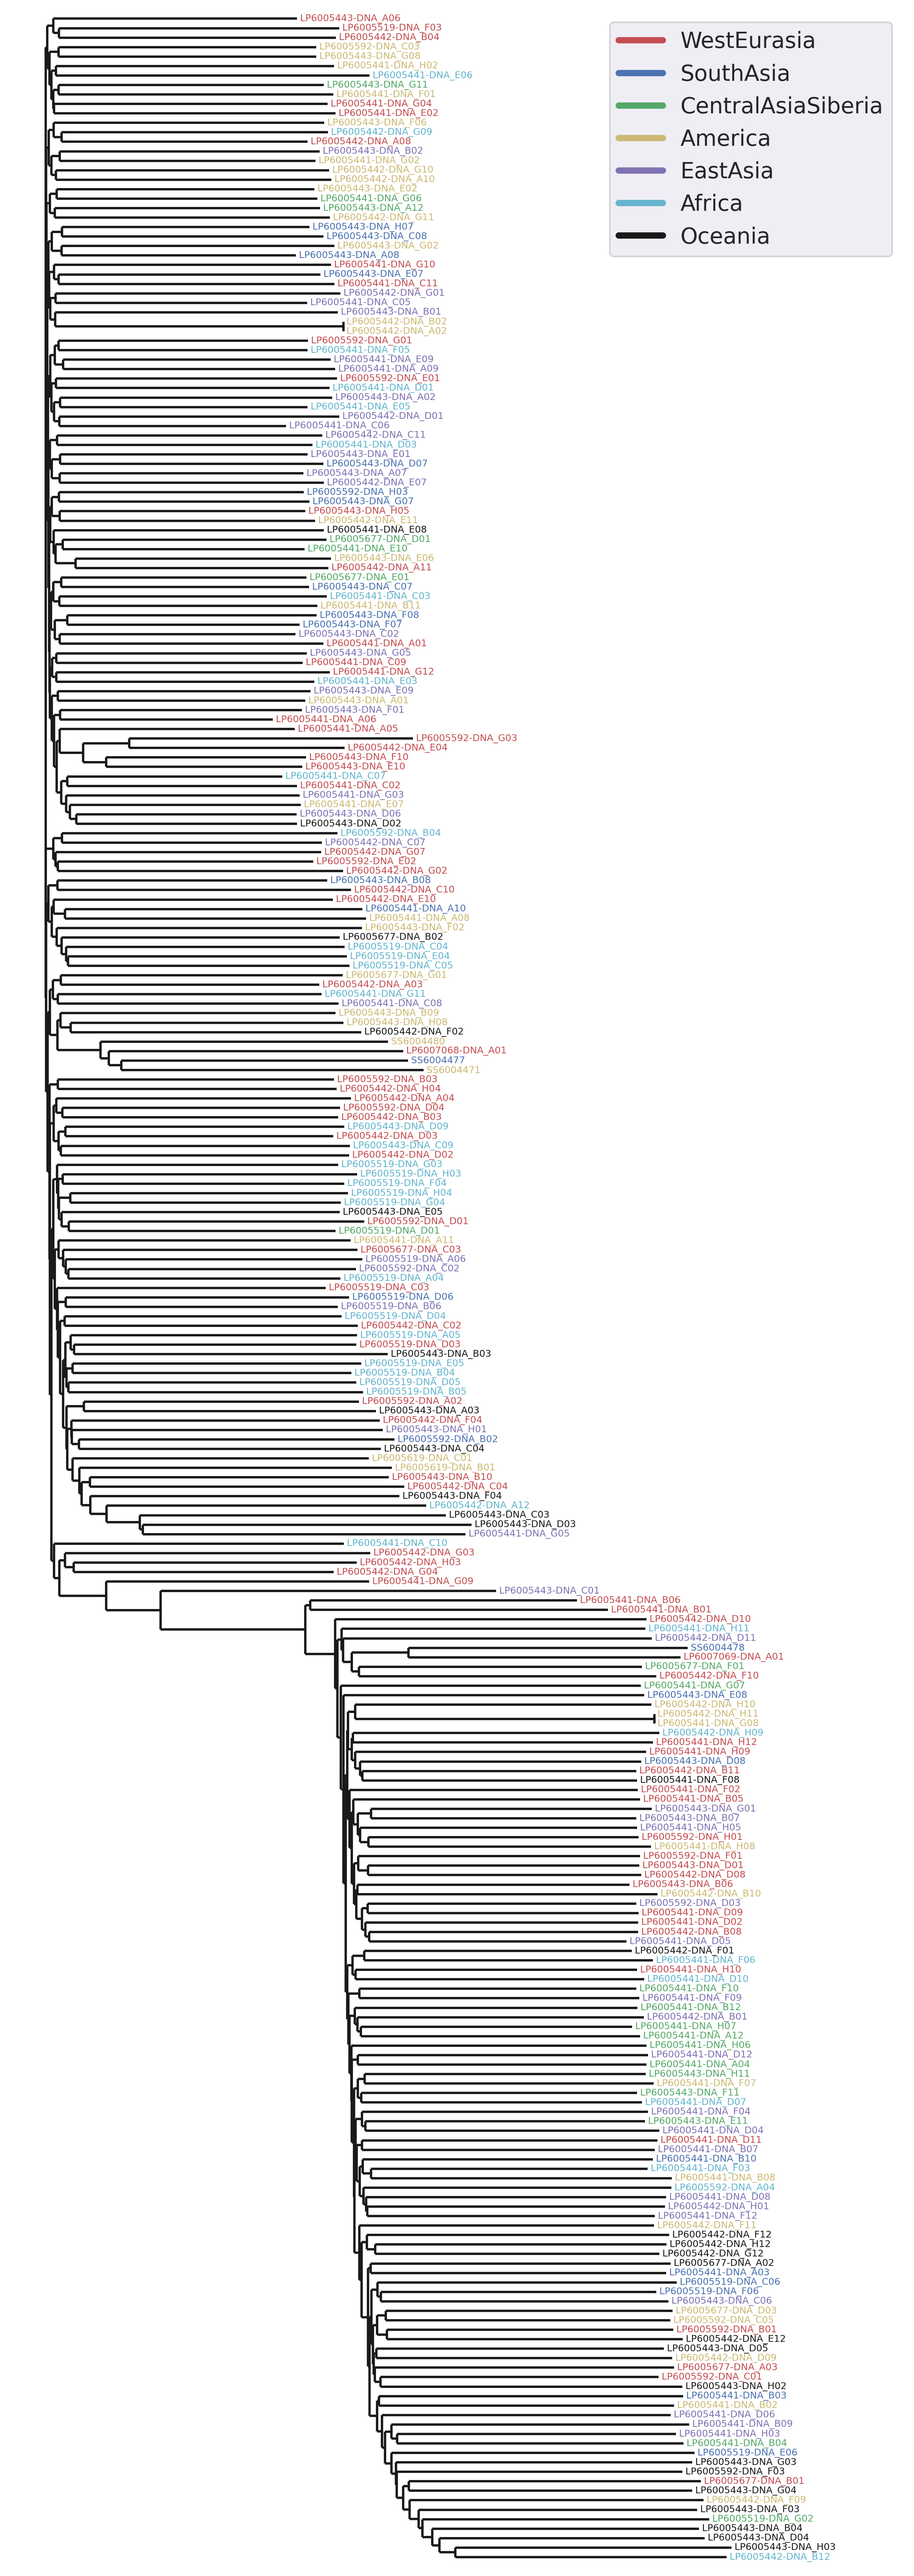

In [52]:
from Bio import Phylo
from io import StringIO 
import pylab
from matplotlib.lines import Line2D

handle = StringIO(str(tree.to_newick(labels=labels, include_distance=True)))
tree_2 = Phylo.read(handle, "newick")
tree_2.ladderize()

matplotlib.rc('font', size=6)
    # set the size of the figure
fig = plt.figure(figsize=(10, 70), dpi=300)
    # alternatively
    # fig.set_size_inches(10, 40)
axes = fig.add_subplot(3, 1, 1)
fig.tight_layout()
Phylo.draw(tree_2, 
           axes=axes, 
           do_show=False,
           label_colors= row_color)
pylab.axis('off')

### CUSTOM LEGEND
custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='m', lw=4),
                Line2D([0], [0], color='c', lw=4),
                Line2D([0], [0], color='k', lw=4)]

#fig, ax = plt.subplots()
plt.legend(custom_lines, ['WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'America', 'EastAsia', 'Africa','Oceania'],  loc =0, prop={'size': 14})

#plt.savefig('neighbor-joining-tree_euclidean.png')

In [53]:
from biotite.sequence.phylo import upgma

#features = features.sort_index()

#names.get_indices()
labels = list(counts.index)
#labels = list(features['10-Region'])
tree = biotite.sequence.phylo.upgma(dist_matrix)
t = print(tree.to_newick(labels=labels, include_distance=True))



(((((((SS6004480:19.553359985351562,LP6007068-DNA_A01:19.553359985351562):1.2152862548828125,(SS6004477:20.062000274658203,SS6004471:20.062000274658203):0.7066459655761719):1.174489974975586,(((((((((((((((((((((((((((((((((((((((LP6005677-DNA_G01:19.073272705078125,LP6005443-DNA_G02:19.073272705078125):0.1815776824951172,((((((((((((((((((((((((((((((((((((((((((((((((((LP6005677-DNA_E01:16.7842960357666,LP6005443-DNA_C07:16.7842960357666):0.37561798095703125,(((LP6005443-DNA_H05:16.962238311767578,((((((((LP6005443-DNA_F10:13.486699104309082,LP6005443-DNA_E10:13.486699104309082):2.48500919342041,LP6005441-DNA_A05:15.971708297729492):0.18128395080566406,(((LP6005443-DNA_D06:15.025593757629395,LP6005443-DNA_D02:15.025593757629395):0.5532073974609375,LP6005441-DNA_E07:15.578801155090332):0.2548379898071289,(LP6005441-DNA_G03:15.70185375213623,((LP6005441-DNA_C07:14.738106727600098,LP6005441-DNA_A06:14.738106727600098):0.4993619918823242,LP6005441-DNA_C02:15.237468719482422):0.4643850326

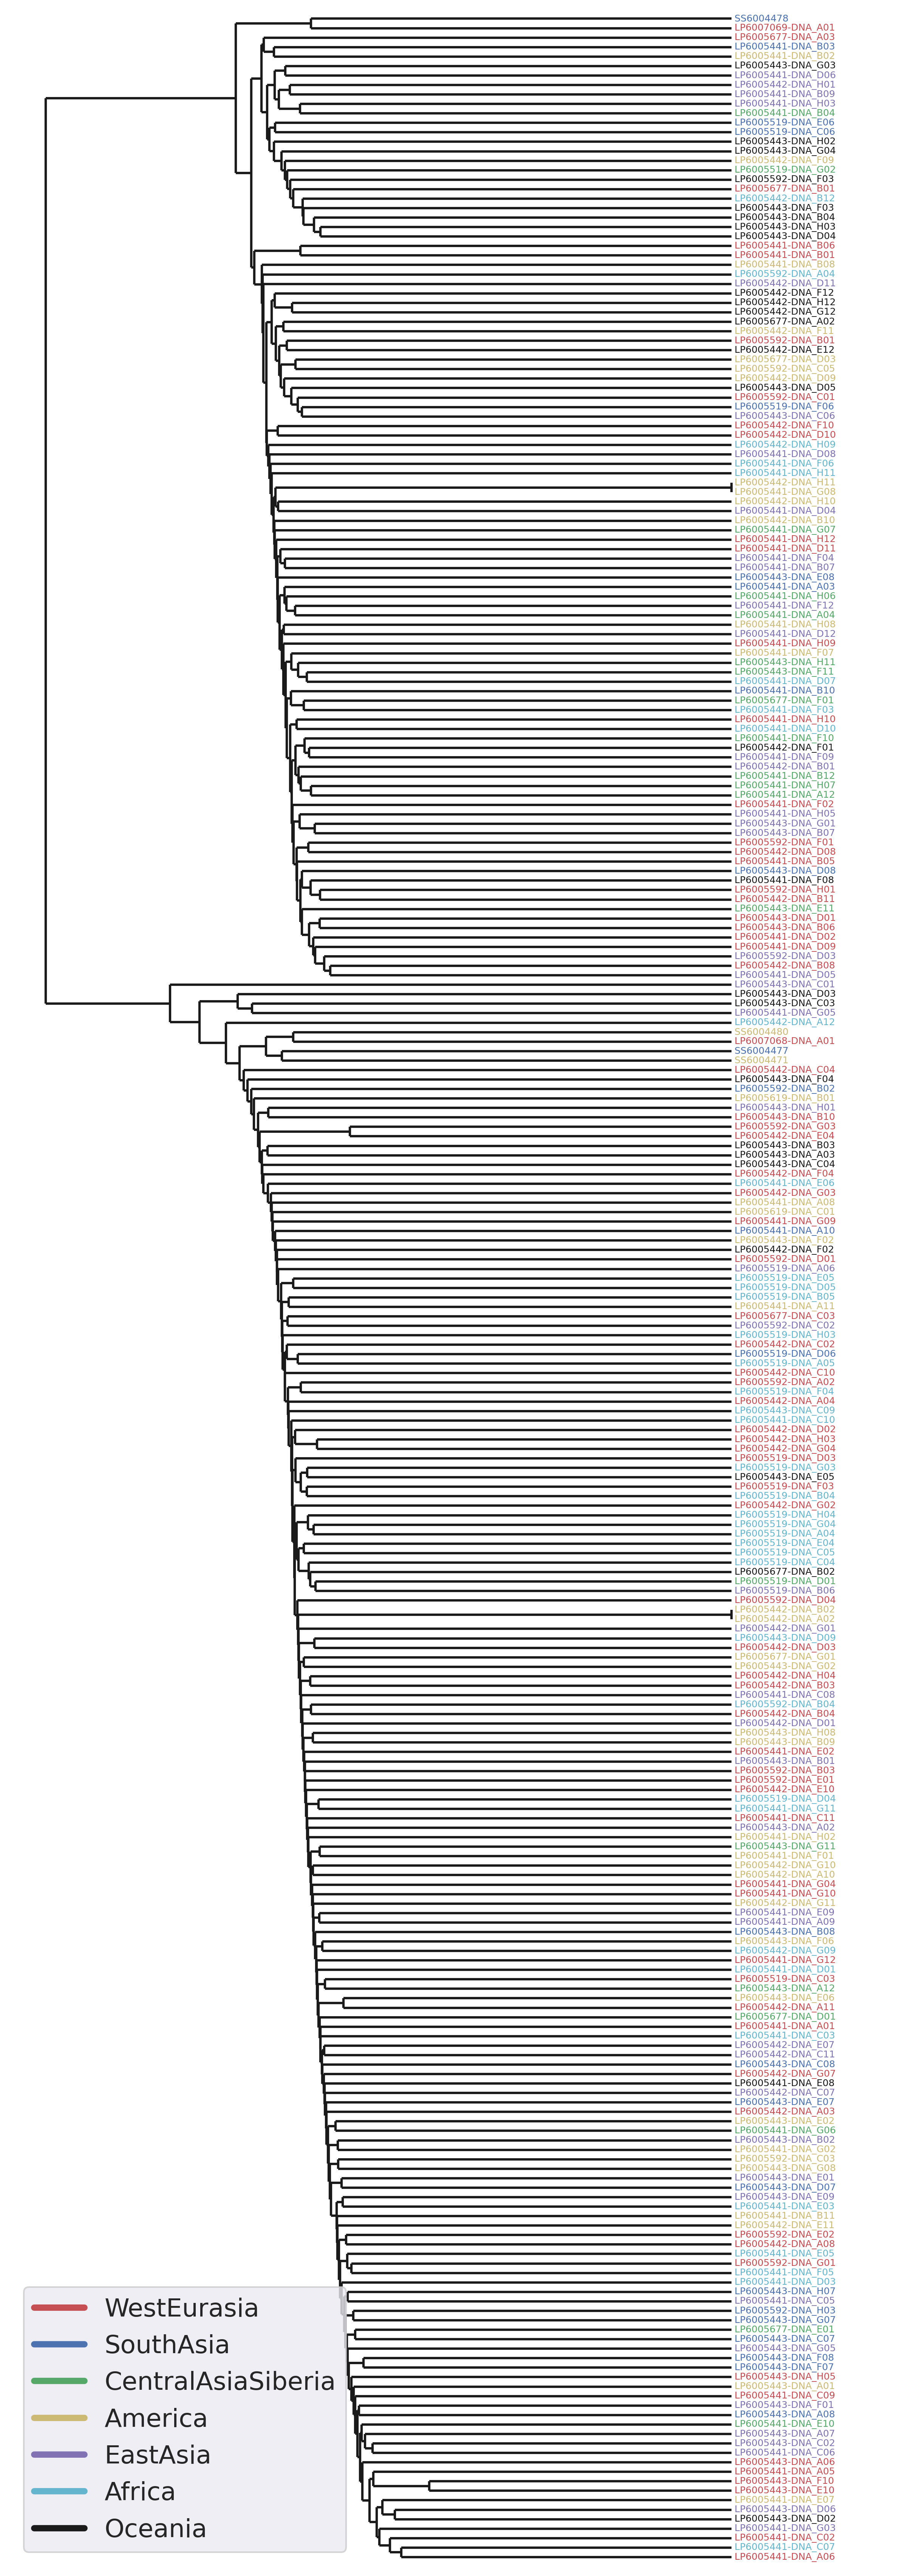

In [54]:
from Bio import Phylo
from io import StringIO 
from matplotlib.lines import Line2D
import pylab

handle = StringIO(str(tree.to_newick(labels=labels, include_distance=True)))
tree_2 = Phylo.read(handle, "newick")
tree_2.ladderize()

matplotlib.rc('font', size=6)
#matplotlib.rc('font', size=6)
    # set the size of the figure
#fig = plt.figure(figsize=(20, 80), dpi=300)
fig = plt.figure(figsize=(10, 70), dpi=300)
    # alternatively
    # fig.set_size_inches(10, 40)
axes = fig.add_subplot(3, 1, 1)
fig.tight_layout()
Phylo.draw(tree_2, 
           axes=axes, 
           do_show=False,
           label_colors= row_color)
pylab.axis('off')

### CUSTOM LEGEND
custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='m', lw=4),
                Line2D([0], [0], color='c', lw=4),
                Line2D([0], [0], color='k', lw=4)]

#fig, ax = plt.subplots()
plt.legend(custom_lines, ['WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'America', 'EastAsia', 'Africa','Oceania'],  loc =3, prop={'size': 16})

#plt.savefig('upgma-tree_euclidean.png')
#plt.legend(row_color, loc ="upper left")
#plt.savefig('upgma-tree.pdf')
#Phylo.write(tree_2, "egfr-family-annotated.xml", "phyloxml")